In [240]:
%reload_ext autoreload
%autoreload 2

In [241]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [243]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import TrialChoice,Decode
from spyglass.shijiegu.helpers import TrialChoice,Decode

In [20]:
nwb_copy_file_name = 'eliot20221018_.nwb'

In [22]:
def populate_mark_indicators(
        spikesorting_selection_keys: list,
        mark_param_name='default',
        position_info_param_name='default'
):
    # Populate spike sorting
    SpikeSortingSelection().insert(
        spikesorting_selection_keys,
        skip_duplicates=True,
    )
    SpikeSorting.populate(spikesorting_selection_keys)

    # Skip any curation
    curation_keys = [Curation.insert_curation(
        key) for key in spikesorting_selection_keys]

    CuratedSpikeSortingSelection().insert(
        curation_keys,
        skip_duplicates=True
    )
    CuratedSpikeSorting.populate(
        CuratedSpikeSortingSelection() & curation_keys)

    # Populate marks
    mark_parameters_keys = pd.DataFrame(CuratedSpikeSorting & curation_keys)
    mark_parameters_keys['mark_param_name'] = mark_param_name
    mark_parameters_keys = (mark_parameters_keys
                            .loc[:, UnitMarkParameters.primary_key]
                            .to_dict('records'))
    UnitMarkParameters().insert(
        mark_parameters_keys,
        skip_duplicates=True
    )
    UnitMarks.populate(UnitMarkParameters & mark_parameters_keys)

    # Compute mark indicators for each position epoch
    nwb_file_name = spikesorting_selection_keys[0]['nwb_file_name']
    position_interval_names = (IntervalPositionInfo() & {
        'nwb_file_name': nwb_file_name,
        'position_info_param_name': position_info_param_name
    }).fetch('interval_list_name')

    for interval_name in tqdm(position_interval_names):
        position_interval = (
            IntervalList &
            {'nwb_file_name': nwb_file_name,
             'interval_list_name': interval_name})

        marks_selection = ((UnitMarks & mark_parameters_keys) *
                           position_interval)
        marks_selection = (pd.DataFrame(marks_selection)
                           .loc[:, marks_selection.primary_key]
                           .to_dict('records'))
        UnitMarksIndicatorSelection.insert(
            marks_selection, skip_duplicates=True)
        UnitMarksIndicator.populate(marks_selection)

In [32]:
def thresholder_sort(sort_interval_name,populate=True):
    artifact_params_name='ampl_100_prop_05_2ms'
    #sort_interval_name='04_Seq2Session2'

    artifact_key=(ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name} 
                              & {'artifact_params_name': artifact_params_name}
                              & {'sort_interval_name':sort_interval_name})
    # fetch, and there should be 2 entries, one from left cannula (group 100), and one from right cannula (group 101)
    artifact_removed_name_list=artifact_key.fetch('artifact_removed_interval_list_name')
    assert len(artifact_removed_name_list)==2

    artifact_time_list=[]
    artifact_removed_time_list=[]
    for artifact_removed_name in artifact_removed_name_list:
        artifact_time_list.append((ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name,'artifact_removed_interval_list_name':artifact_removed_name}).fetch1('artifact_times'))
        artifact_removed_time_list.append((IntervalList() & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':artifact_removed_name}).fetch1('valid_times'))

    artifact_time_list=interval_union(artifact_time_list[0],artifact_time_list[1])
    artifact_removed_time_list=interval_list_intersect(
        np.array(artifact_removed_time_list[0]),np.array(artifact_removed_time_list[1]))
    
    # find tetrodes
    tetrode_with_cell=np.unique((SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name}).fetch('sort_group_id'))
    tetrode_with_cell=np.setdiff1d(tetrode_with_cell,[100,101])
    
    # insert into individual tetrodes ArtifactRemovedIntervalList
    artifact_params_name='ampl_1500_prop_075_1ms'
    sorting_keys=[]
    for tetrode in tetrode_with_cell:
        print(tetrode)
        artifact_key = {'nwb_file_name' : nwb_copy_file_name,
                    'sort_interval_name' : sort_interval_name,
                    'sort_group_id' : tetrode,
                    'preproc_params_name': 'franklab_tetrode_hippocampus',
                    'team_name': 'Shijie Gu'}                    
        artifact_key['artifact_params_name'] = artifact_params_name

        ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)

        artifact_key['artifact_times']=artifact_time_list
        artifact_key['artifact_removed_valid_times']=artifact_removed_time_list

        artifact_name=(nwb_copy_file_name+'_'+sort_interval_name+'_'+str(artifact_key['sort_group_id'])+'_'+
                       artifact_key['preproc_params_name']+'_'+artifact_params_name+'_artifact_removed_valid_times')

        artifact_key['artifact_removed_interval_list_name']=artifact_name

        ArtifactRemovedIntervalList().insert1(artifact_key,skip_duplicates=True)

        IntervalList().insert1({'nwb_file_name' : nwb_copy_file_name,
                               'interval_list_name':artifact_name,
                               'valid_times':artifact_removed_time_list},skip_duplicates=True)

        artifact_key.pop('artifact_params_name')
        artifact_key.pop('artifact_times')
        artifact_key.pop('artifact_removed_valid_times')

        artifact_key['sorter'] = 'clusterless_thresholder'
        artifact_key['sorter_params_name'] = 'default'

        SpikeSortingSelection.insert1(artifact_key, skip_duplicates=True)

        sorting_keys.append(artifact_key.copy())
    
    if populate:
        SpikeSorting.populate({'nwb_file_name':nwb_copy_file_name,
                               'artifact_params_name': artifact_params_name, # make sure to inlude this
                               'sort_interval_name':sort_interval_name})
    return sorting_keys

In [252]:
(IntervalPositionInfo() & {
        'nwb_file_name': nwb_copy_file_name,
        'position_info_param_name': 'default_decoding'})

*position_info *nwb_file_name *interval_list analysis_file_ head_position_ head_orientati head_velocity_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default_decodi eliot20221018_ pos 1 valid ti eliot20221018_ 81e93b78-9857- 732bb199-4225- 67f16d86-7ab0-
default_decodi eliot20221018_ pos 10 valid t eliot20221018_ 6d89a575-b1b1- c3691281-4ed6- 538a9583-4a1f-
default_decodi eliot20221018_ pos 3 valid ti eliot20221018_ 89831b86-0bce- c05f2a35-4dbc- 0fc7b73d-bcbd-
default_decodi eliot20221018_ pos 4 valid ti eliot20221018_ bbbbb248-8225- 6652f5aa-2bcb- b19fc9f3-6f80-
default_decodi eliot20221018_ pos 6 valid ti eliot20221018_ 02608f54-0b57- ebb26897-c04e- 6e1586ec-41c5-
default_decodi eliot20221018_ pos 8 valid ti eliot20221018_ 0907fd44-e45d- a7c7e607-e41f- bfe7708e-9c8b-
 (Total: 6)

In [237]:
position_interval_names

array(['pos 1 valid times', 'pos 11 valid times', 'pos 5 valid times',
       'pos 3 valid times', 'pos 9 valid times', 'pos 5 valid times',
       'pos 11 valid times', 'pos 3 valid times', 'pos 7 valid times',
       'pos 1 valid times', 'pos 9 valid times', 'pos 7 valid times'],
      dtype=object)

## Marks

The first thing we need are the marks for the clusterless decoding. First, sort spikes by thresholder.


### artifact times

In [23]:
ArtifactDetection & {'nwb_file_name':nwb_copy_file_name}

*nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *artifact_para artifact_t artifact_r artifact_remov
+------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +--------+ +--------+ +------------+
eliot20221018_ 100            02_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 100            04_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 100            05_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 100            07_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 100            09_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 100            11_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 101            02_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 101            04_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 101            05_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 101            07_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 101            09_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
eliot20221018_ 101            11_Seq2Session franklab_tetro Shijie Gu     ampl_100_prop_ =BLOB=     =BLOB=     eliot20221018_
 (Total: 12)

In [262]:
IntervalList_pd=pd.DataFrame(IntervalList & {'nwb_file_name': nwb_copy_file_name})

# select position timestamps, only maze sessions are selected
position_interval=[]
session_interval=[]
for i in IntervalList_pd.index:
    interval=IntervalList_pd['interval_list_name'][i]
    if interval[-8:-1]=='Session':
        session_interval.append(interval)
        position_interval.append('pos '+str(i)+' valid times')

In [41]:
'''
artifact times
'''

for session in session_interval:
    sorting_keys=thresholder_sort(session)

0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 23, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_02_Seq2Session1_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2022 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 0, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 2, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 4, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 5, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 13, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 14, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 16, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 17, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 20, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 23, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 26, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 27, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 28, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 29, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 30, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 31, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_04_Seq2Session2_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


detect peaks:   0%|          | 0/355 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 0, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 2, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 4, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 5, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 13, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 14, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 16, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 17, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 20, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 23, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 26, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 27, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 28, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 29, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 30, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 31, 'sort_interval_name': '05_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/2070 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 0, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 2, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 4, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 5, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 13, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 14, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 16, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 17, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 20, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 23, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 26, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 27, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 28, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 29, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 30, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 31, 'sort_interval_name': '07_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_07_Seq2Session4_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1892 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
27
28
29
30
31
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 0, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 2, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 4, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 5, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 13, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 27, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 28, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 29, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 30, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 31, 'sort_interval_name': '09_Seq2Session5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_09_Seq2Session5_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1717 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 0, 'sort_interval_name': '11_Seq2Session6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_11_Seq2Session6_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1813 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 2, 'sort_interval_name': '11_Seq2Session6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_11_Seq2Session6_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1813 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 4, 'sort_interval_name': '11_Seq2Session6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_11_Seq2Session6_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1813 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 5, 'sort_interval_name': '11_Seq2Session6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_11_Seq2Session6_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1813 [00:00<?, ?it/s]

/home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_sorting.py:204: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sampling_frequency=recording.get_sampling_frequency(),


Saving sorting results...
Running spike sorting on {'nwb_file_name': 'eliot20221018_.nwb', 'sort_group_id': 13, 'sort_interval_name': '11_Seq2Session6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_11_Seq2Session6_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times'}...


detect peaks:   0%|          | 0/1813 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [79]:
ArtifactRemovedIntervalList & {'nwb_file_name' : nwb_copy_file_name}

*artifact_remo nwb_file_name  sort_group_id  sort_interval_ preproc_params team_name     artifact_param artifact_r artifact_t
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +--------+ +--------+
eliot20221018_ eliot20221018_ 0              02_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 0              04_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 0              05_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 0              07_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 0              09_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 0              11_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 2              02_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 2              04_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 2              05_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 2              07_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 2              09_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
eliot20221018_ eliot20221018_ 2              11_Seq2Session franklab_tetro Shijie Gu     ampl_1500_prop =BLOB=     =BLOB=    
   ...
 (Total: 108)

In [45]:
SpikeSorting() & {'nwb_file_name' : nwb_copy_file_name,
                  'sort_interval_name':'04_Seq2Session2'}

*nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo sorting_path   time_of_sort  
+------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+
eliot20221018_ 0              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393716    
eliot20221018_ 2              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393718    
eliot20221018_ 4              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393719    
eliot20221018_ 5              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393721    
eliot20221018_ 13             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393722    
eliot20221018_ 14             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393723    
eliot20221018_ 16             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393724    
eliot20221018_ 17             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393726    
eliot20221018_ 20             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393727    
eliot20221018_ 23             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393729    
eliot20221018_ 26             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393730    
eliot20221018_ 27             04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ /stelmo/nwb/so 1685393731    
   ...
 (Total: 16)

### Skip Curation

In [46]:
# Skip any curation
curation_keys = [Curation.insert_curation(key) for key in sorting_keys]

In [52]:
for session in session_interval:
    sorting_keys=thresholder_sort(session,populate=False)
    
    curation_keys = [Curation.insert_curation(key) for key in sorting_keys]
    CuratedSpikeSortingSelection().insert(
        curation_keys,
        skip_duplicates=True)
    
    CuratedSpikeSorting.populate(
        CuratedSpikeSortingSelection() & curation_keys)
    
    mark_parameters_keys = pd.DataFrame(CuratedSpikeSorting & curation_keys)
    mark_parameters_keys['mark_param_name'] = 'default'
    mark_parameters_keys = (mark_parameters_keys.loc[:, UnitMarkParameters.primary_key].to_dict('records'))
    
    UnitMarkParameters().insert(
        mark_parameters_keys,
        skip_duplicates=True)
    
    UnitMarks.populate(UnitMarkParameters & mark_parameters_keys)

0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31
0
2
4
5
13
14
16
17
20
23
26
27
28
29
30
31


In [53]:
Curation() & {'nwb_file_name' : nwb_copy_file_name}

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo parent_curatio curation_l merge_grou quality_me description    time_of_creati
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +--------+ +--------+ +--------+ +------------+ +------------+
0              eliot20221018_ 0              02_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398027    
0              eliot20221018_ 0              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398042    
0              eliot20221018_ 0              05_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398060    
0              eliot20221018_ 0              07_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398108    
0              eliot20221018_ 0              09_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398206    
0              eliot20221018_ 0              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685397750    
0              eliot20221018_ 2              02_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398028    
0              eliot20221018_ 2              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398043    
0              eliot20221018_ 2              05_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398061    
0              eliot20221018_ 2              07_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398109    
0              eliot20221018_ 2              09_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685398207    
0              eliot20221018_ 2              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685397751    
   ...
 (Total: 96)

In [81]:
UnitMarks & {'nwb_file_name': 'eliot20221018_.nwb'}

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo *mark_param_na analysis_file_ marks_object_i
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0              eliot20221018_ 0              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ 18b2c4e4-b3fb-
0              eliot20221018_ 2              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ 6dbc2d8e-2732-
0              eliot20221018_ 4              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ 807cdcb8-a1e2-
0              eliot20221018_ 5              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ d8b08ee0-ace3-
0              eliot20221018_ 13             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ 88326d87-4e71-
0              eliot20221018_ 14             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ c9717f9b-0e3a-
0              eliot20221018_ 16             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ d1addb78-f27f-
0              eliot20221018_ 17             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ 012f29d2-9b5d-
0              eliot20221018_ 20             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ edd1bcd3-6bb4-
0              eliot20221018_ 23             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ ab5eb552-e1bf-
0              eliot20221018_ 26             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ 8945bb20-16a9-
0              eliot20221018_ 27             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        eliot20221018_ f646d670-df1f-
   ...
 (Total: 16)

In [228]:
# Compute mark indicators
nwb_copy_file_name = sorting_keys[0]['nwb_file_name']
position_interval_names = (IntervalPositionInfo() & {
        'nwb_file_name': nwb_copy_file_name,
        'position_info_param_name': 'default_decoding'
    }).fetch('interval_list_name')

interval_name='pos 10 valid times'
position_interval = (
        IntervalList &
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': interval_name})

marks_selection = ((UnitMarks & mark_parameters_keys) * position_interval)
marks_selection = (pd.DataFrame(marks_selection)
                   .loc[:, marks_selection.primary_key]
                   .to_dict('records'))
UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)

In [229]:
UnitMarksIndicatorSelection & {'nwb_file_name': 'eliot20221018_.nwb'}

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo *mark_param_na *interval_list *sampling_rate
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0              eliot20221018_ 0              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 2              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 4              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 5              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 13             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 14             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 16             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 17             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 20             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 23             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 26             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
0              eliot20221018_ 27             11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ default        pos 10 valid t 500.0         
   ...
 (Total: 48)

In [230]:
Curation & {'nwb_file_name': 'eliot20221018_.nwb',
            'sort_interval_name':'11_Seq2Session6',
            'sort_group_id':2}

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo parent_curatio curation_l merge_grou quality_me description    time_of_creati
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +--------+ +--------+ +--------+ +------------+ +------------+
0              eliot20221018_ 2              11_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221018_ -1             =BLOB=     =BLOB=     =BLOB=                    1685397751    
 (Total: 1)

In [113]:
key={'nwb_file_name': 'eliot20221018_.nwb',
     'sort_interval_name':'11_Seq2Session6',
     'sort_group_id':0}
recording = Curation.get_recording(key)

In [93]:
trace=recording.get_traces()

In [98]:
sorting = Curation.get_curated_sorting(key)

In [99]:
sorting

NpzFolderSorting: 1 units - 1 segments - 30.0kHz

In [ ]:
UnitMarksIndicator.populate(marks_selection)
        

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_N7X1XBBCH9.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_34EADRROG5.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_D4UMKYPCP7.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_RXRB9WCL3E.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_7JYID5KJPC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_J5ME1EW44E.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_EDUMDFXEX2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_UWQSJ0ZOMK.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_Z92G6YMROM.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_PLZXXYBYFH.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

Writing new NWB file eliot20221018_IJWVCBDL4V.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

After we've populated this table, we can fetch all the mark indicators from a set of electrodes using the `fetch_xarray` method. `xarray` is just a python package that produces labeled multidimensional arrays. The decoding results will also come in this format.

In [60]:
marks = (UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name': 'pos 11 valid times',   
}).fetch_xarray()
marks.shape

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

(176693, 4, 16)

After you get the marks, it is important to visualize them to make sure they look right. We can use the `plot_all_marks` method of UnitMarksIndicator to quickly plot each mark feature against the other for each electrode.

Here it is important to look for things that look overly correlated (strong diagonal on the off-diagonal plots) and for extreme amplitudes.

In [78]:
#marks_single

In [86]:
~np.isnan(marks_single)

<xarray.DataArray ()>
array(0)

In [ ]:
marks_single = (UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name,
    'sort_group_id': 0,
    'interval_list_name': 'pos 10 valid times',   
}).fetch_xarray()
UnitMarksIndicator.plot_all_marks(marks_single)

## Position

After the marks look good, you'll need to load/populate the 2D position data. This comes from the `IntervalPositionInfo` table. See the position tutorial for more information. Note that we will need to upsample the position data (which is done here via the `default_decoding` parameters) to match the sampling frequency that we intend to decode in (2 ms time bins or 500 Hz sampling rate)

Next we populate/load the linearized position tables. Again refer to the linear position tutorials for more information.

In [64]:
from spyglass.common.common_position import IntervalLinearizedPosition

linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': 'pos 3 valid times',
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220420_680I7IT916.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)


linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.650478e+09              NaN                 0                   NaN   
1.650478e+09              NaN                 0                   NaN   
1.650478e+09              NaN                 0                   NaN   
1.650478e+09              NaN                 0                   NaN   
1.650478e+09              NaN                 0                   NaN   
...                       ...               ...                   ...   
1.650480e+09         1.231313                 0            210.335450   
1.650480e+09         1.234147                 0            210.335647   
1.650480e+09         1.236981                 0            210.335843   
1.650480e+09         1.239815                 0            210.336040   
1.650480e+09         1.242649                 0            210.336237   

              projected_y_position  
time                                
1.650478e+09                   NaN  
1.650478e+09                   NaN  
1.650478e+09                   NaN  
1.650478e+09                   NaN  
1.650478e+09                   NaN  
...                            ...  
1.650480e+09            232.771656  
1.650480e+09            232.768829  
1.650480e+09            232.766001  
1.650480e+09            232.763174  
1.650480e+09            232.760347  

[1093826 rows x 4 columns]

We should also quickly visualize the linear position in order to sanity check the values. Here we plot the 2D position projected to its corresponding 1D segment.

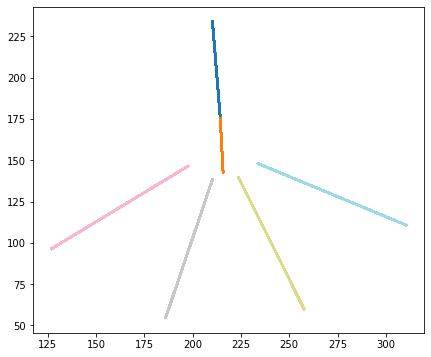

In [28]:
plt.figure(figsize=(7, 6))
plt.scatter(linear_position_df.projected_x_position, linear_position_df.projected_y_position,
            c=linear_position_df.track_segment_id, cmap='tab20', s=1)

We should also plot the linearized position itself to make sure it is okay.

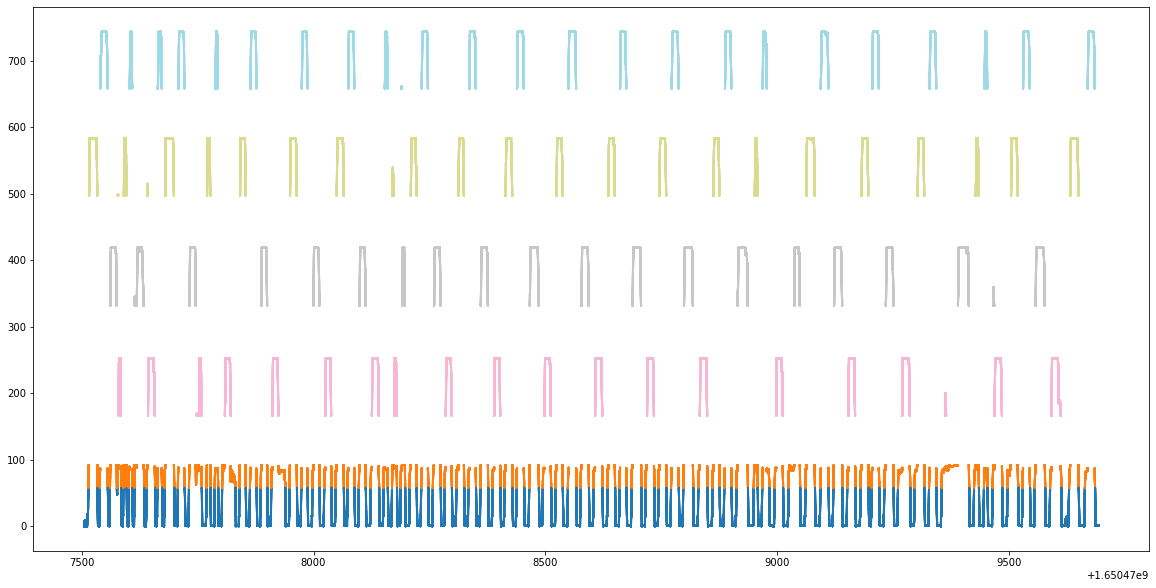

In [29]:
plt.figure(figsize=(20, 10))
plt.scatter(linear_position_df.index, linear_position_df.linear_position, s=1,
            c=linear_position_df.track_segment_id, cmap='tab20')

Okay now that we've looked at the data, we should quickly verify that all our data is the same size.

We also want to make sure we have valid ephys data and valid position data for decoding. Here we only have one valid time interval, but if we had more than one, we should decode on each interval separately.

In [67]:
sort_interval_name='04_Seq2Session2'
pos_interval_name='pos 3 valid times'

key = {}
key['interval_list_name'] = sort_interval_name
key['nwb_file_name'] = nwb_copy_file_name

interval = (IntervalList &
            {'nwb_file_name': key['nwb_file_name'],
             'interval_list_name': key['interval_list_name']}
           ).fetch1('valid_times')

valid_ephys_times = (IntervalList &
                     {'nwb_file_name': key['nwb_file_name'],
                      'interval_list_name': 'raw data valid times'}
                    ).fetch1('valid_times')
position_interval_names = (IntervalPositionInfo &
                           {'nwb_file_name': key['nwb_file_name'],
                            'position_info_param_name': 'default_decoding',
                           }
                          ).fetch('interval_list_name')

valid_pos_times = (IntervalList &
                   {'nwb_file_name': key['nwb_file_name'],
                    'interval_list_name': pos_interval_name}
                  ).fetch1('valid_times')

intersect_interval = interval_list_intersect(
    interval_list_intersect(interval, valid_ephys_times), valid_pos_times)

marks_=[]
linear_position_df_=[]
for i in range(len(intersect_interval)):
    valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])
    
    linear_position_df_.append(linear_position_df.loc[valid_time_slice])
    marks_.append(marks.sel(time=valid_time_slice))

marks=xr.concat(marks_,dim='time')
linear_position_df=pd.concat(linear_position_df_)
marks.shape, linear_position_df.shape

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'pandas.core.frame.DataFrame'>

In [69]:
marks.shape, linear_position_df.shape

((1080566, 4, 21), (1080566, 4))

In [31]:

#position_info = position_info.loc[valid_time_slice]

## Decoding

Okay, now having sanity checked the data, we can finally get to decoding. In the future this will be a pipeline, but for now it is manual as the table structure is still being prototyped. 

In order to set the parameters, we can fetch the default parameters and modify them.

For 1D decoding, it is best to pass in the track graph and track graph parameters we used for linearization in order for the random walk to be handled properly. We can also set the amount of smoothing in the position and mark dimensions: `position_std` and `mark_std` respectively. Finally we set the `block_size`, which controls how many samples get processed at a time so that we don't run out of GPU memory.

In [70]:
from spyglass.decoding.clusterless import ClusterlessClassifierParameters
ClusterlessClassifierParameters()

*classifier_pa classifier fit_params predict_pa
+------------+ +--------+ +--------+ +--------+
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
fork_maze_Haig =BLOB=     =BLOB=     =BLOB=    
fork_maze_Haig =BLOB=     =BLOB=     =BLOB=    
pipt           =BLOB=     =BLOB=     =BLOB=    
pipt_1         =BLOB=     =BLOB=     =BLOB=    
popt           =BLOB=     =BLOB=     =BLOB=    
popt_1         =BLOB=     =BLOB=     =BLOB=    
ppt_1          =BLOB=     =BLOB=     =BLOB=    
pstpt          =BLOB=     =BLOB=     =BLOB=    
pstpt_1        =BLOB=     =BLOB=     =BLOB=    
   ...
 (Total: 16)

In [71]:
from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.clusterless import ClusterlessClassifierParameters

import pprint

#parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_cpu'}).fetch1()
parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu'}).fetch1()

track_graph = (TrackGraph() & {'track_graph_name': '4 arm lumped'}).get_networkx_track_graph()
track_graph_params = (TrackGraph() & {'track_graph_name': '4 arm lumped'}).fetch1()

parameters['classifier_params']['environments'] = [
    Environment(
    track_graph=track_graph,
    edge_order=track_graph_params['linear_edge_order'],
    edge_spacing=track_graph_params['linear_edge_spacing'])]

parameters['classifier_params']['clusterless_algorithm'] = 'multiunit_likelihood_integer'
parameters['classifier_params']['clusterless_algorithm_params'] = {
    'mark_std': 24.0,
    'position_std': 6.0,
    'block_size': 100,
 }

pprint.pprint(parameters)

{'classifier_param_name': 'default_decoding_gpu',
 'classifier_params': {'clusterless_algorithm': 'multiunit_likelihood_integer',
                       'clusterless_algorithm_params': {'block_size': 100,
                                                        'mark_std': 24.0,
                                                        'position_std': 6.0},
                       'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                        Uniform(environment_name='', environment2_name=None)],
                                                       [Uniform(environment_name='', environment2_name=None),
                                                        Uniform(environment_name='', environment2_name=None)]],
                       'discrete_transition_type': DiagonalDiscrete(diagonal_value=0.98),
                       'environments': [Environment(environment_name='', 

After we set the parameters, we can run the decoding.

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier

GPU_ID = 5

# use context manager to specify which GPU (device)
with cp.cuda.Device(GPU_ID):

    classifier = ClusterlessClassifier(**parameters['classifier_params'])
    classifier.fit(
        position=linear_position_df.linear_position.values,
        multiunits=marks.values,
        **parameters['fit_params']
    )
    results = classifier.predict(
        multiunits=marks.values,
        time=linear_position_df.index,
        **parameters['predict_params']
    )
    logging.info('Done!')

    results

26-Jun-22 15:54:33 Fitting initial conditions...
26-Jun-22 15:54:33 Fitting continuous state transition...
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/replay_trajectory_classification/continuous_state_transitions.py:12: RuntimeWarning: invalid value encountered in true_divide
  x /= x.sum(axis=1, keepdims=True)
26-Jun-22 15:54:34 Fitting discrete state transition
26-Jun-22 15:54:34 Fitting multiunits...
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood_integer.py:82: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood_integer.py:82: RuntimeWarning: invalid value encountered in subtract
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
26-Jun-22 15:54:44 Estimating likelihood

n_electrodes:   0%|          | 0/21 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood_integer.py:445: RuntimeWarning: overflow encountered in add
  log_likelihood[np.ix_(is_spike, is_track_interior)] += np.nan_to_num(


In [76]:
decode_path=os.path.join('/stelmo/shijie/recording_pilot/molly/decoding',nwb_copy_file_name+sort_interval_name+'.nc')
results.to_netcdf(decode_path)

In [78]:
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':sort_interval_name,
     'posterior':decode_path}
Decode().insert1(key,replace=True)

In [ ]:
float(results.time[60000])

Finally, we can plot the decodes to make sure they make sense.

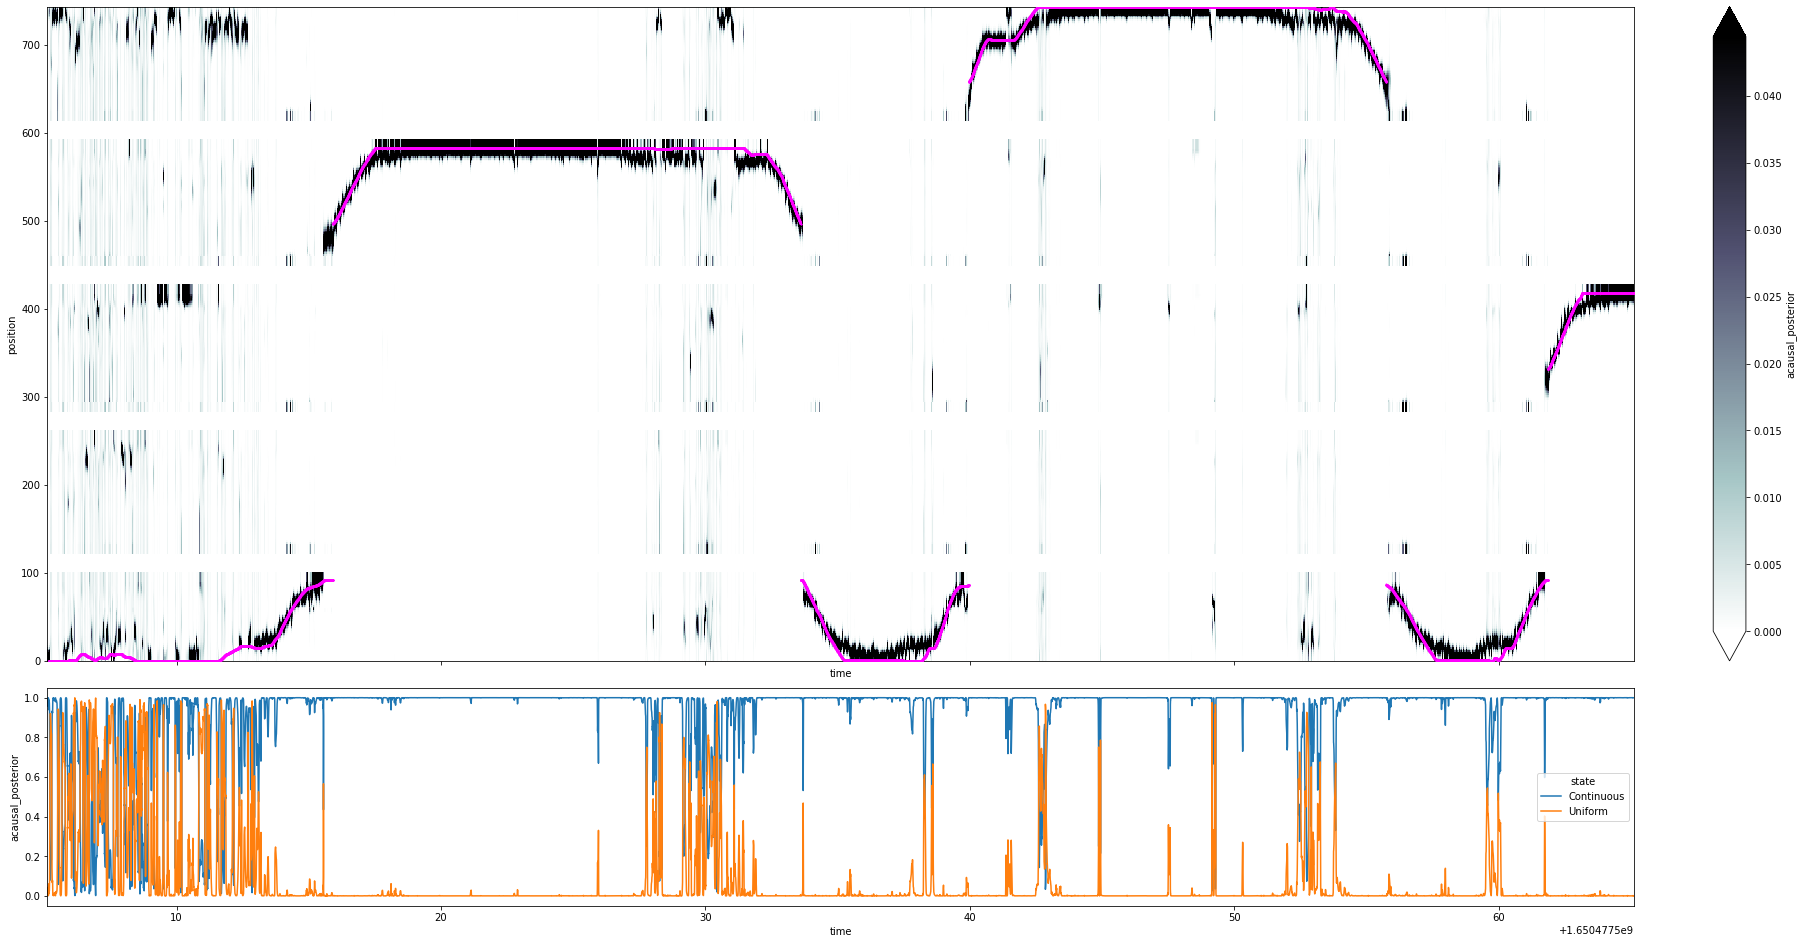

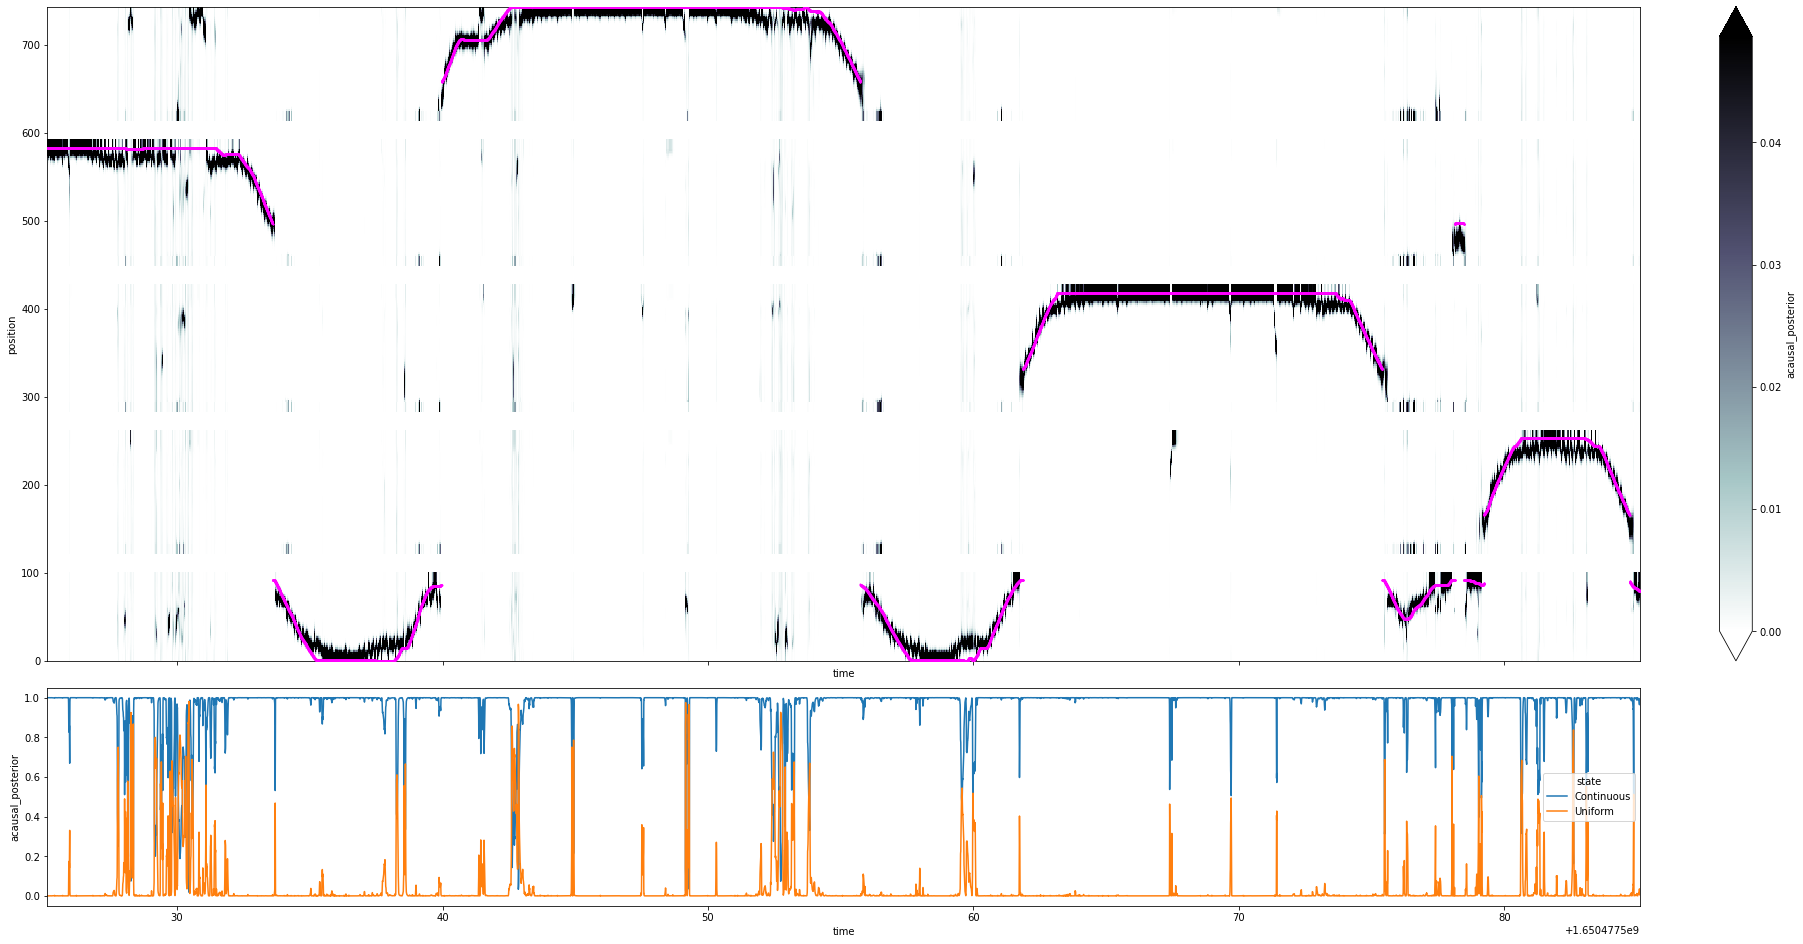

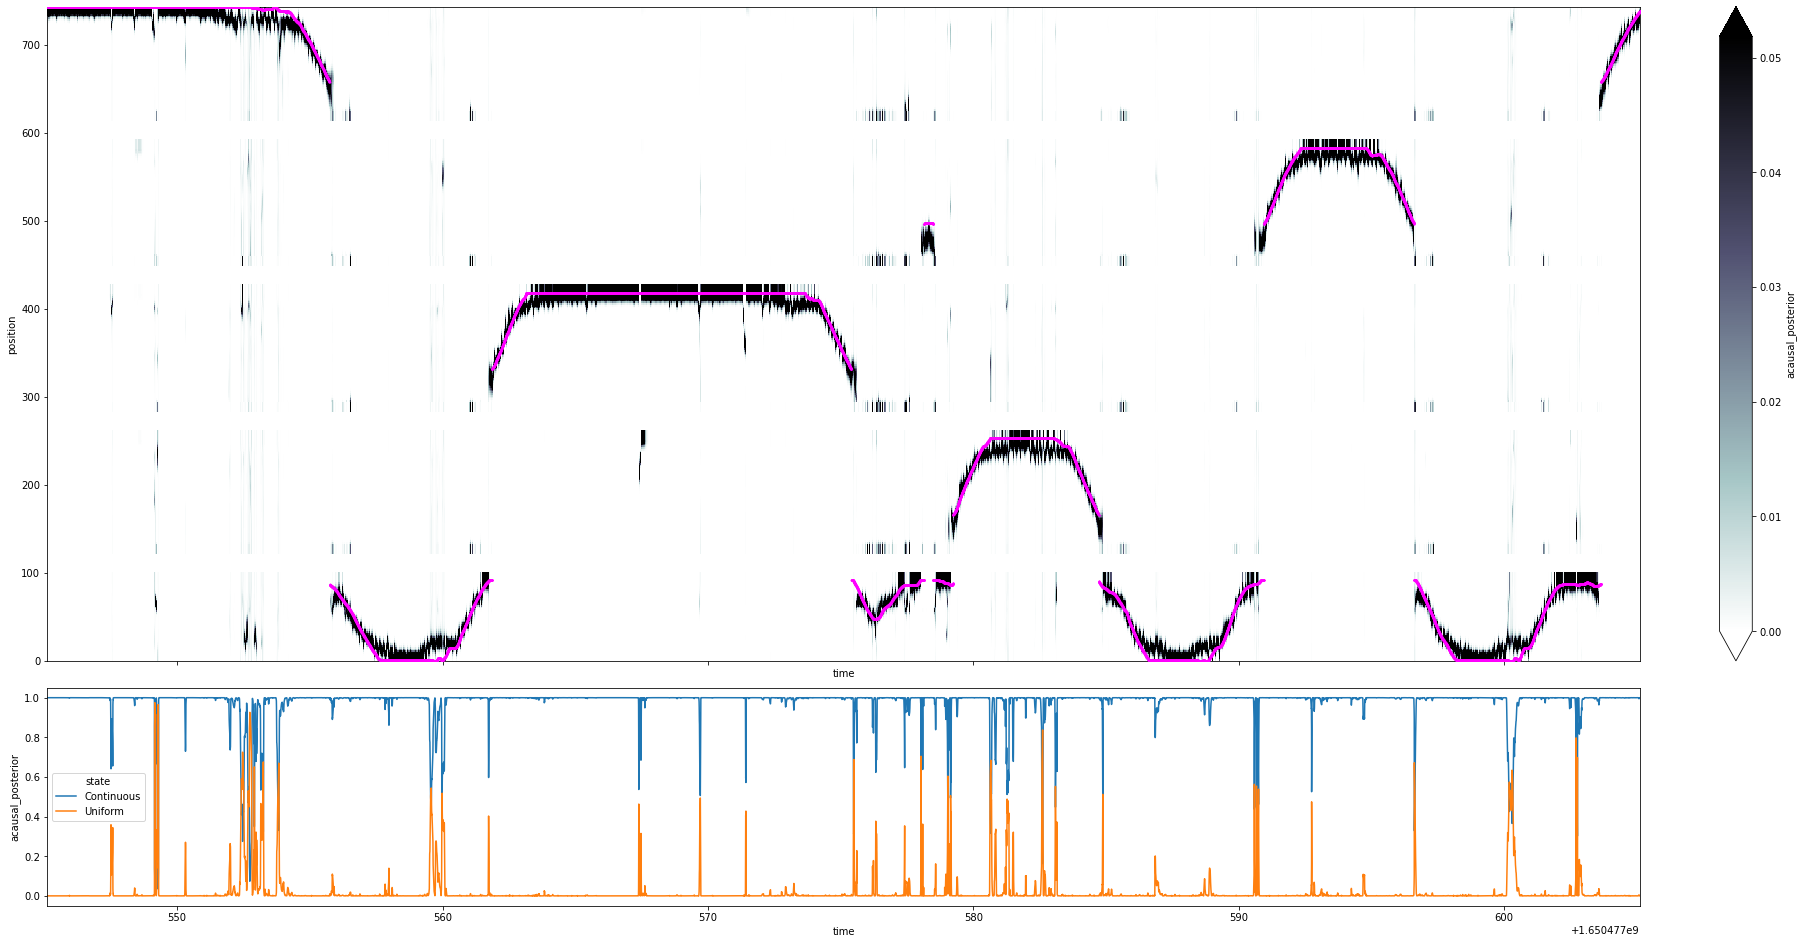

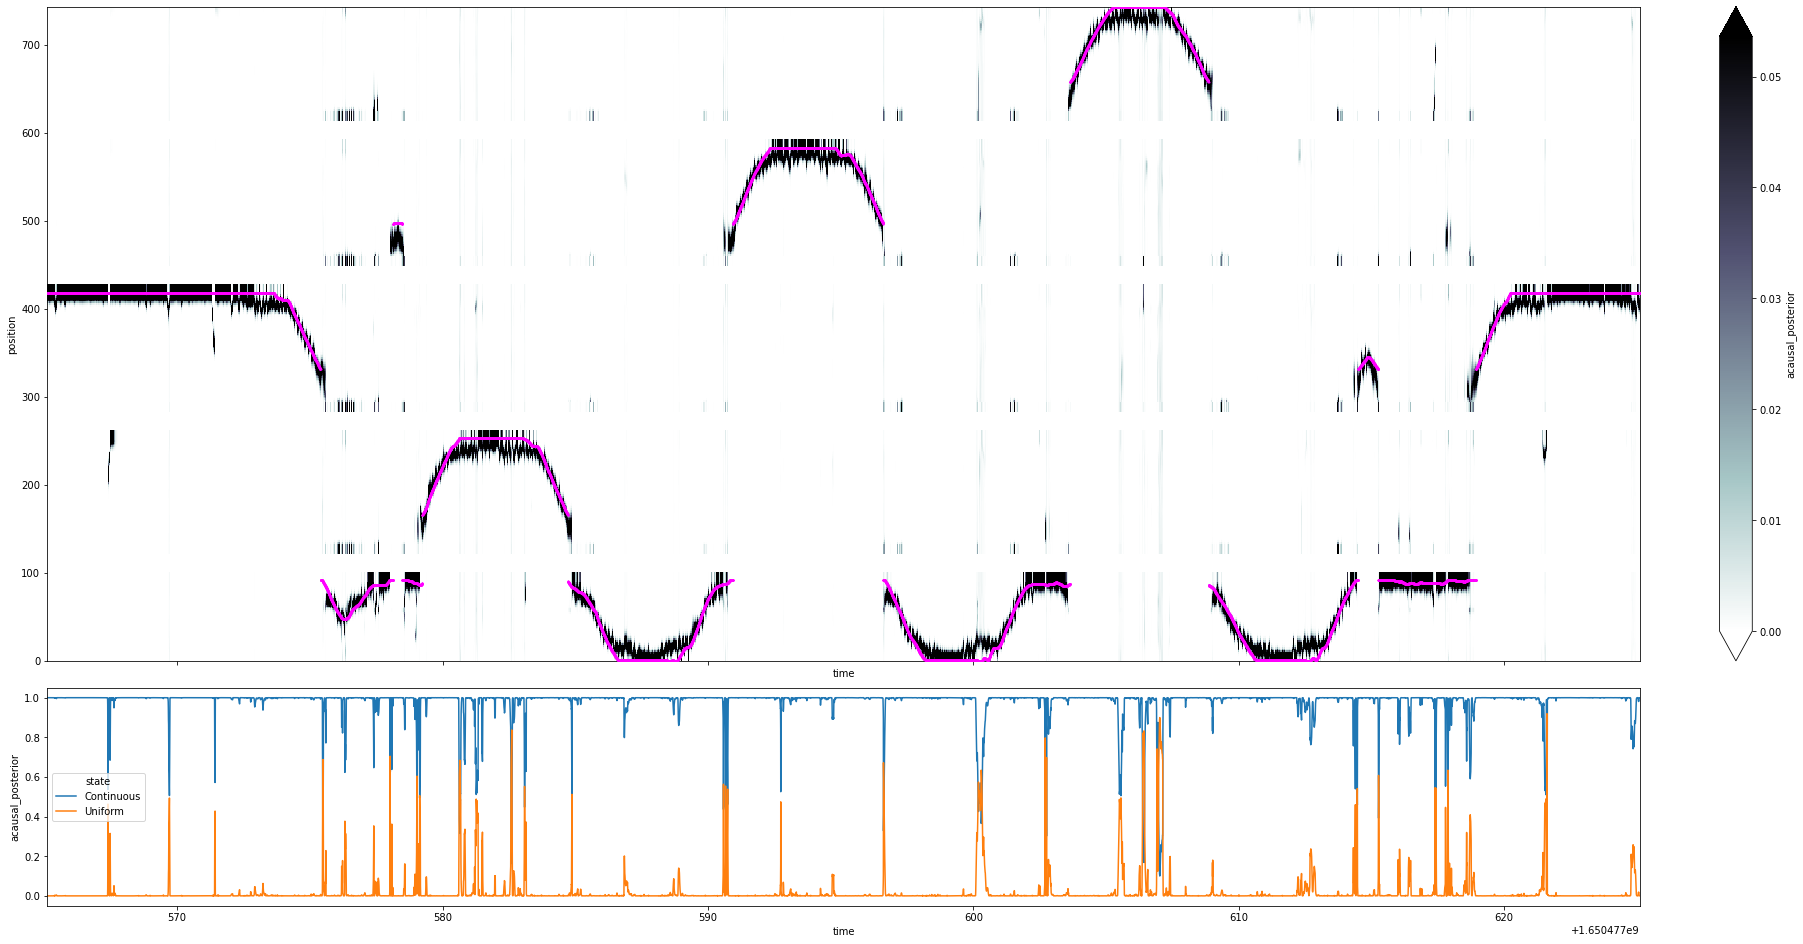

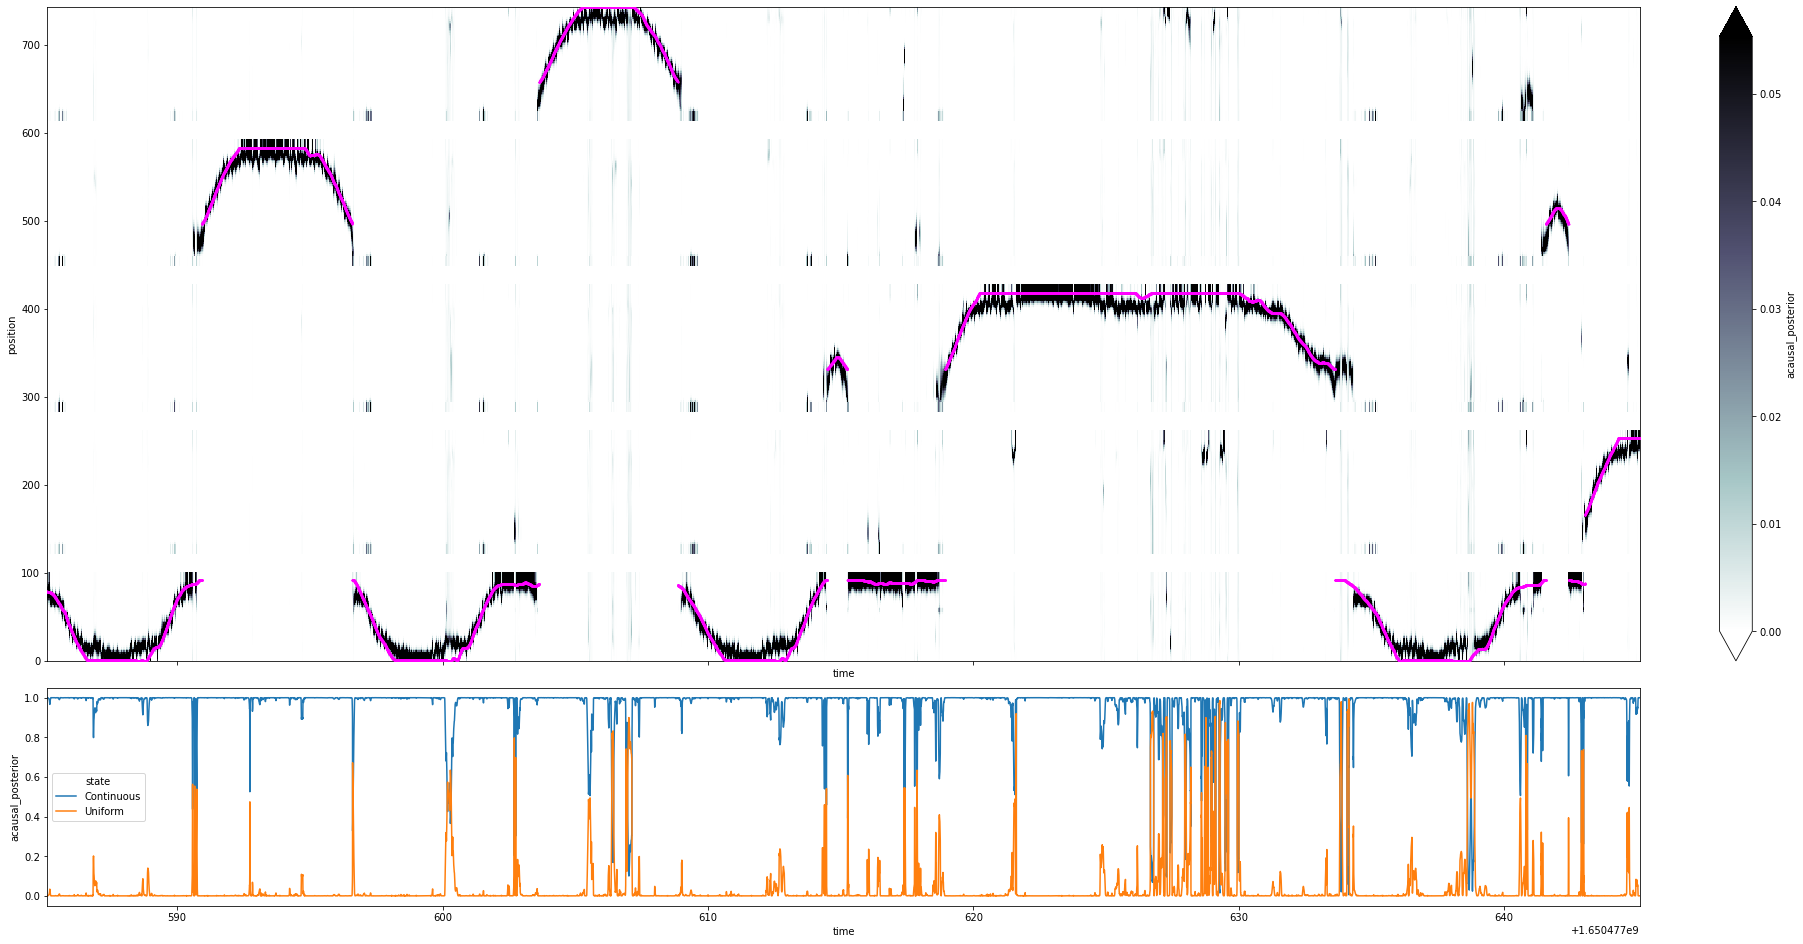

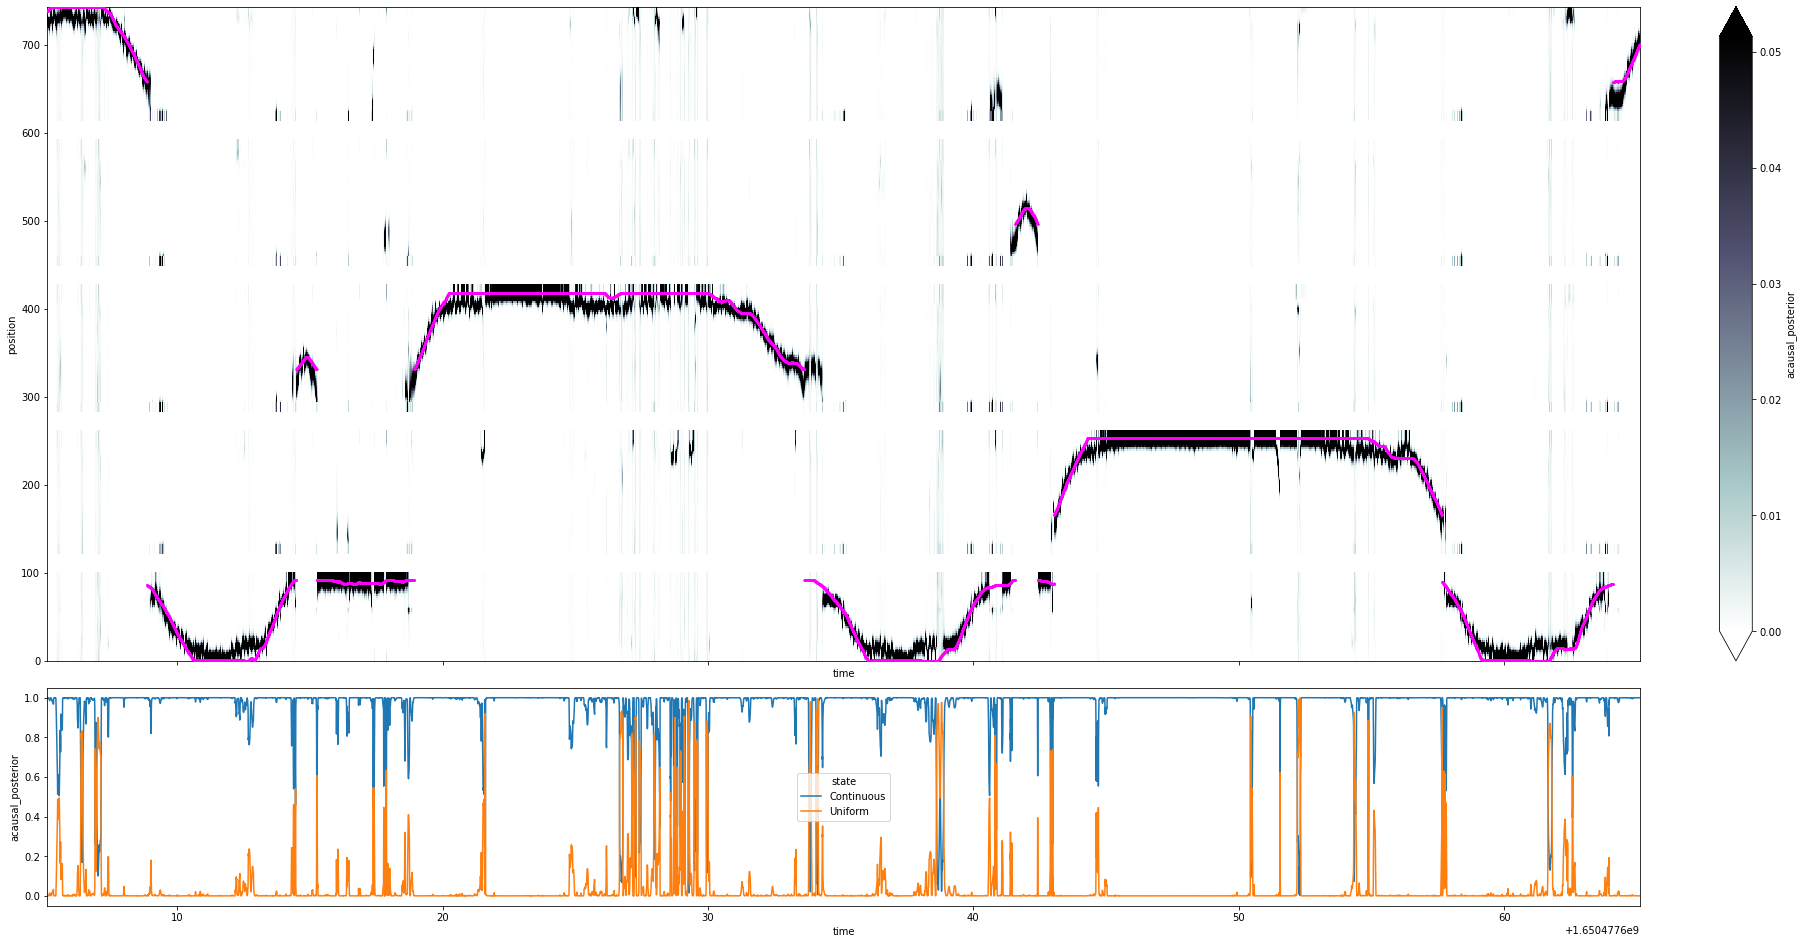

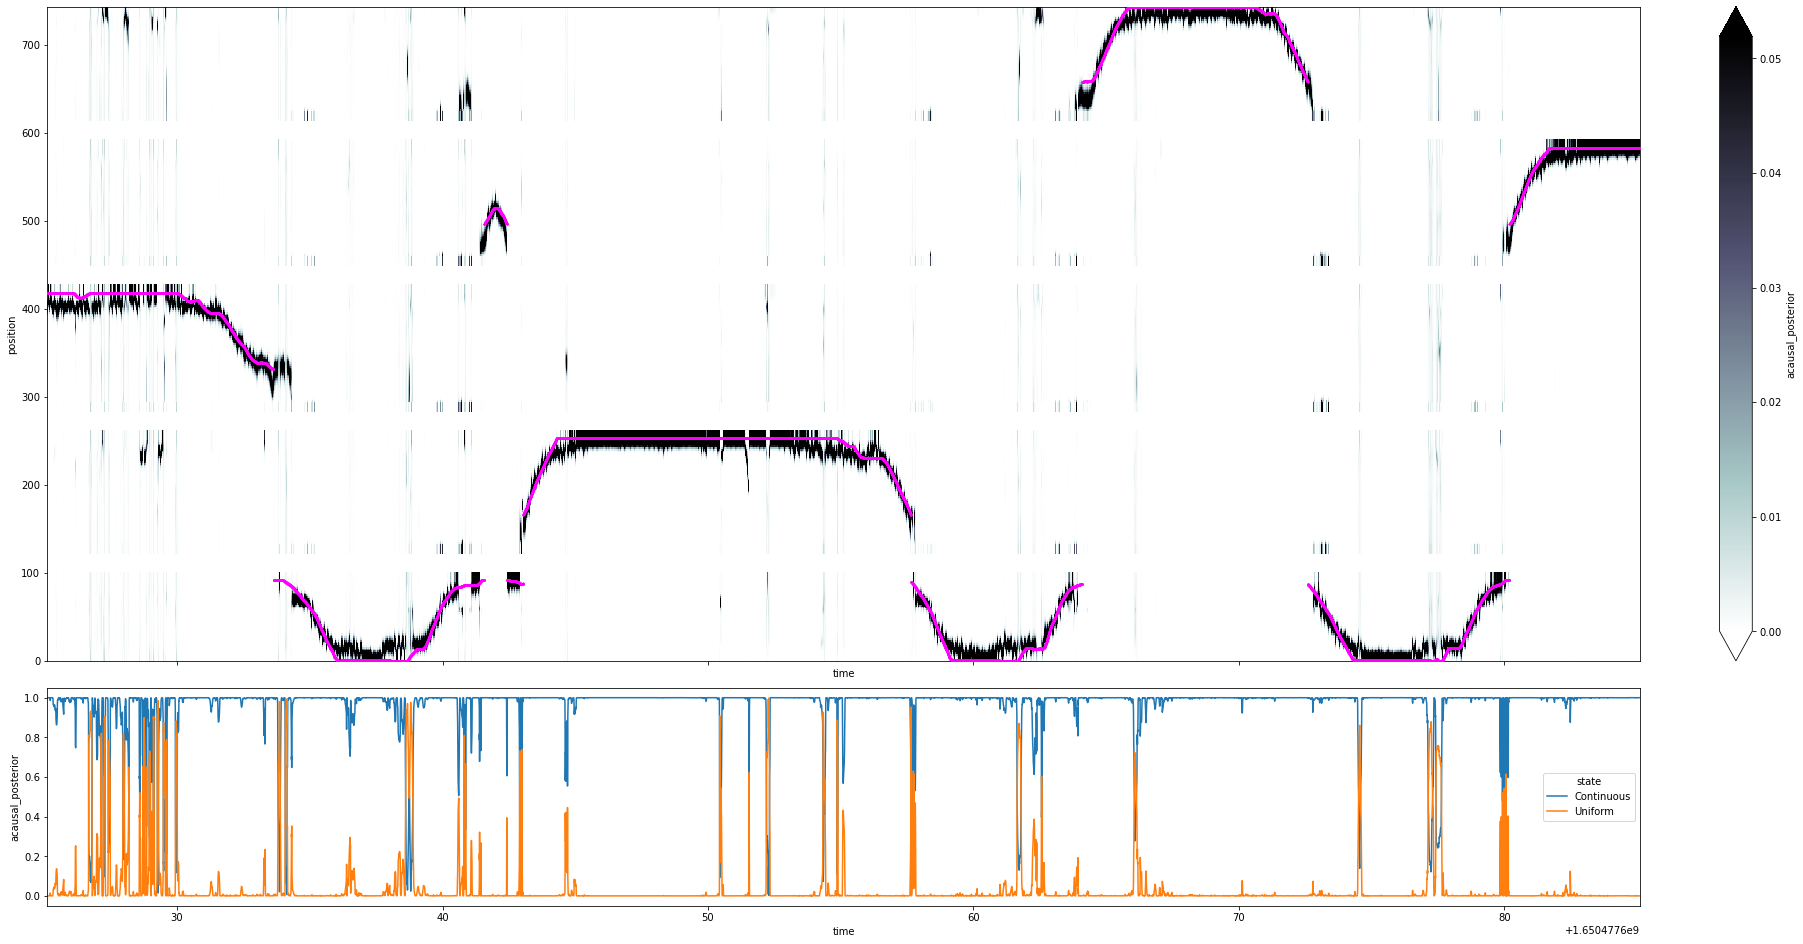

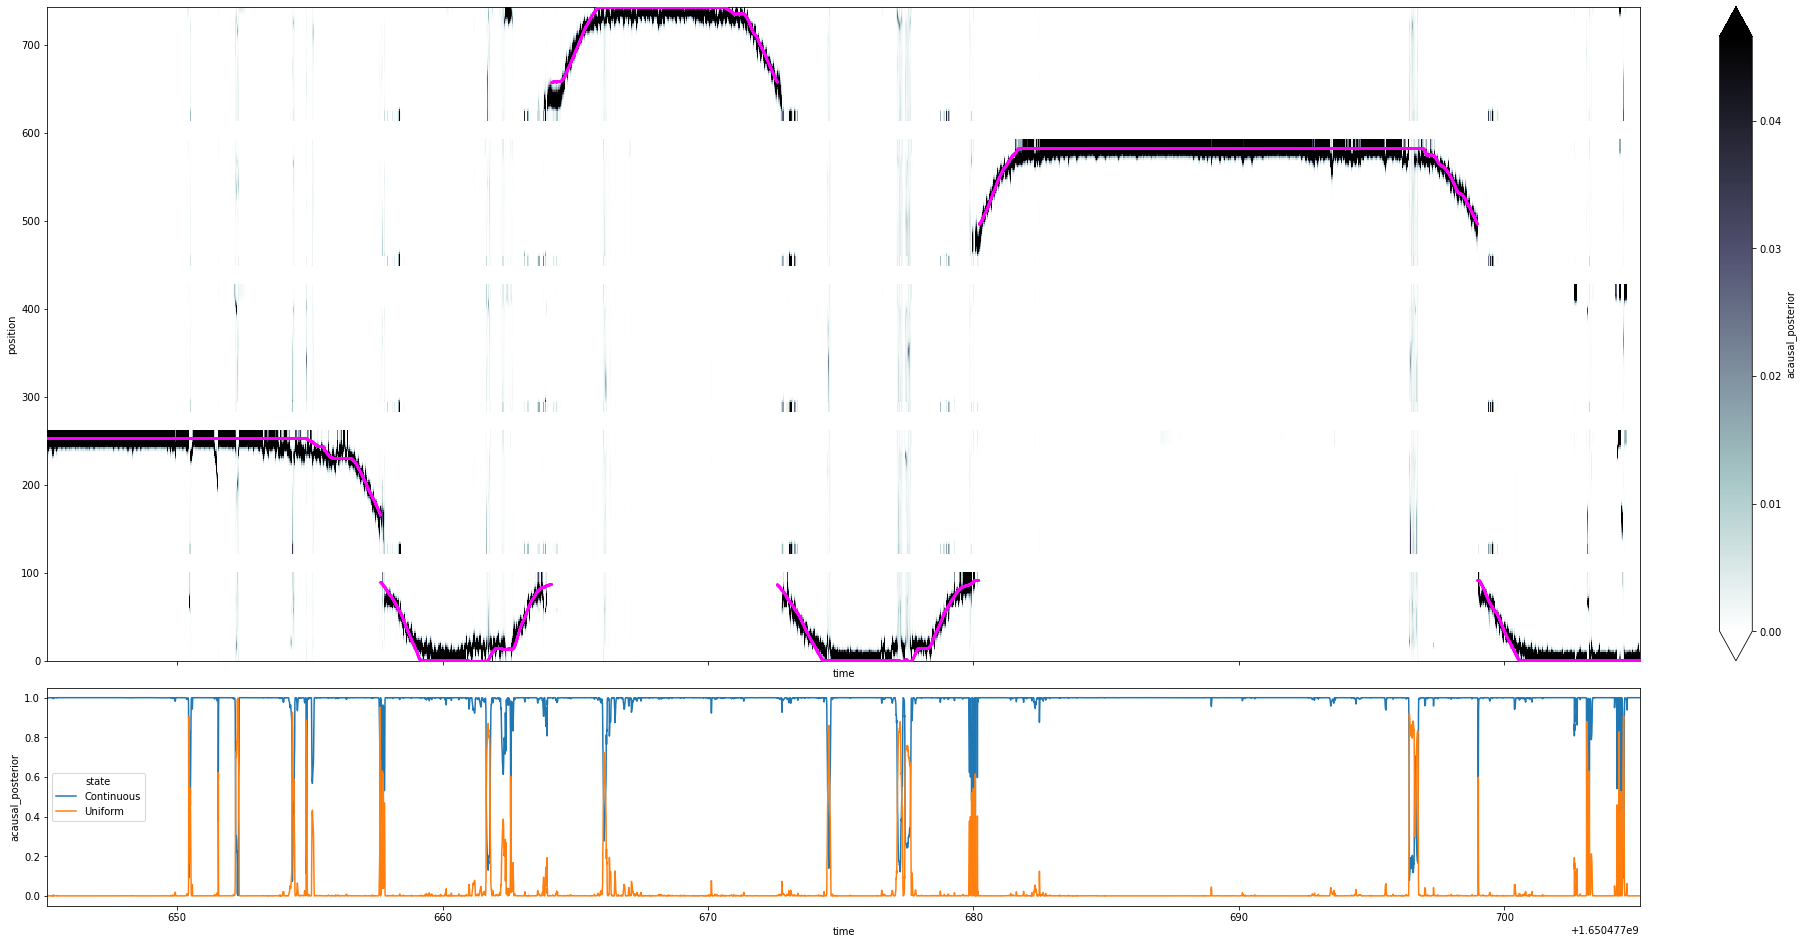

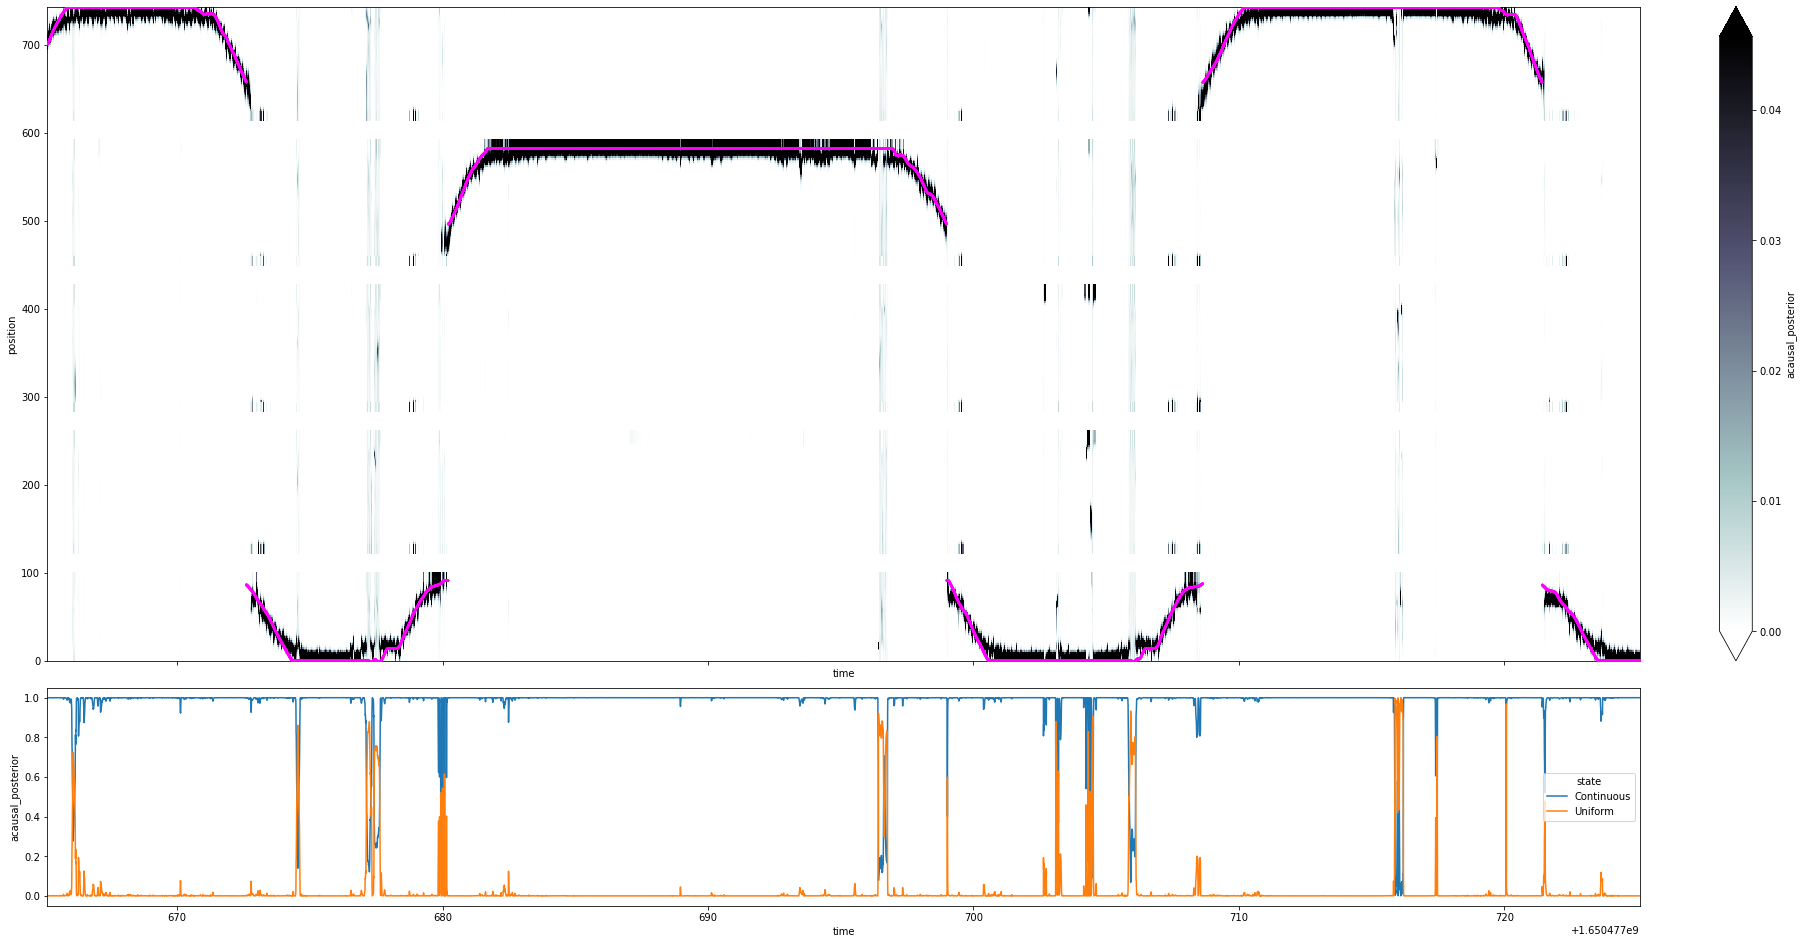

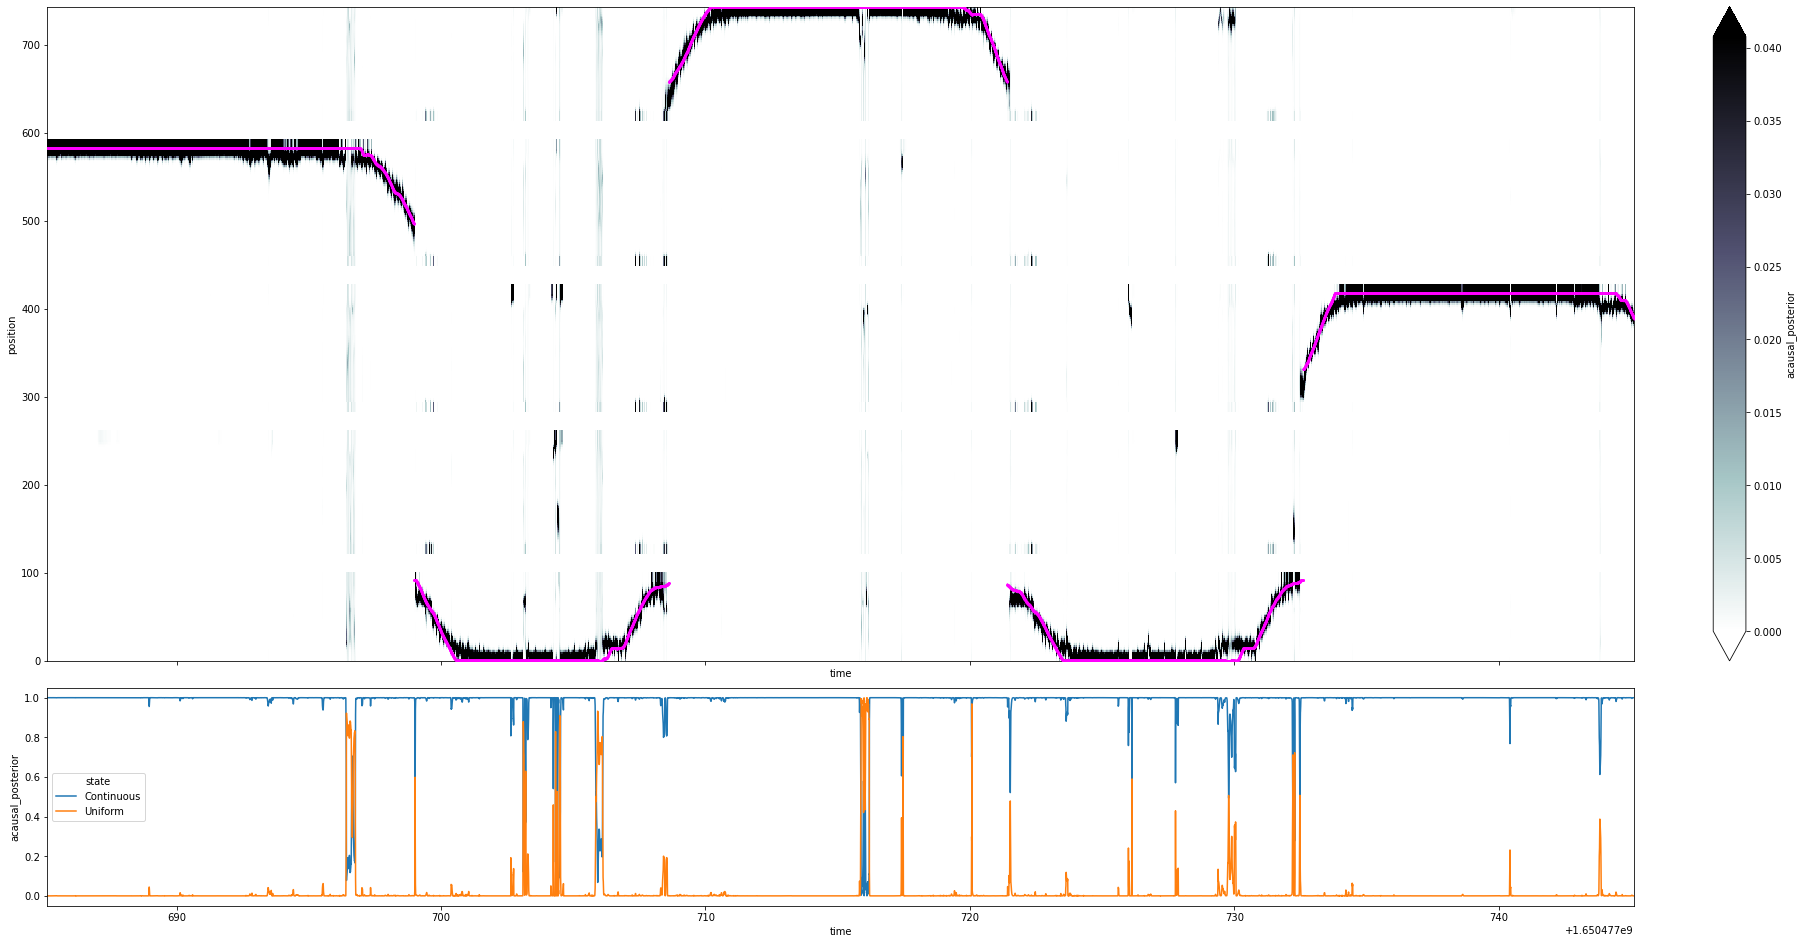

In [79]:
import matplotlib.pyplot as plt
for time_ind in range(0, 100_000, 10_000): #range(0, 600_000, 100_000)
    time_slice = slice(time_ind, time_ind + 30_000)

    fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)
    results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
    axes[0].scatter(linear_position_df.iloc[time_slice].index,
                    linear_position_df.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)
 
    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

In [ ]:
import matplotlib.pyplot as plt

#timestart=111_200
timestart=timestart+500
time_slice = slice(timestart, timestart+500)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(linear_position_df.iloc[time_slice].index,
                linear_position_df.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

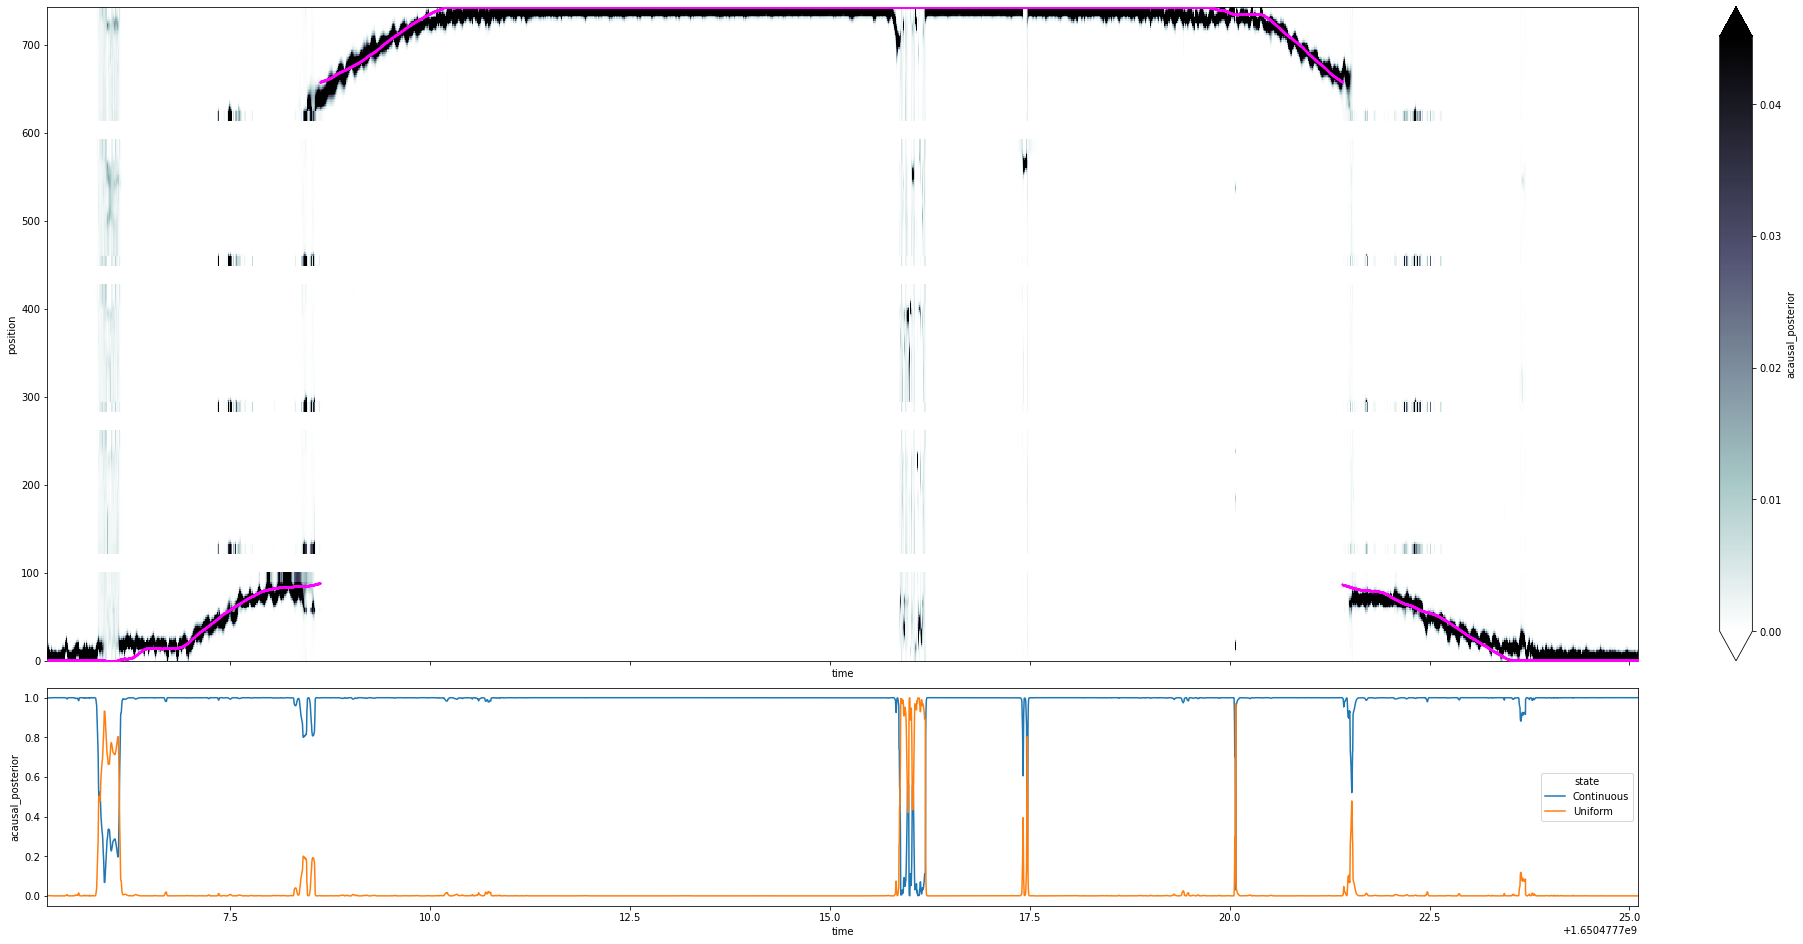

In [134]:
import matplotlib.pyplot as plt

time_slice = slice(100_050, 110_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(linear_position_df.iloc[time_slice].index,
                linear_position_df.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

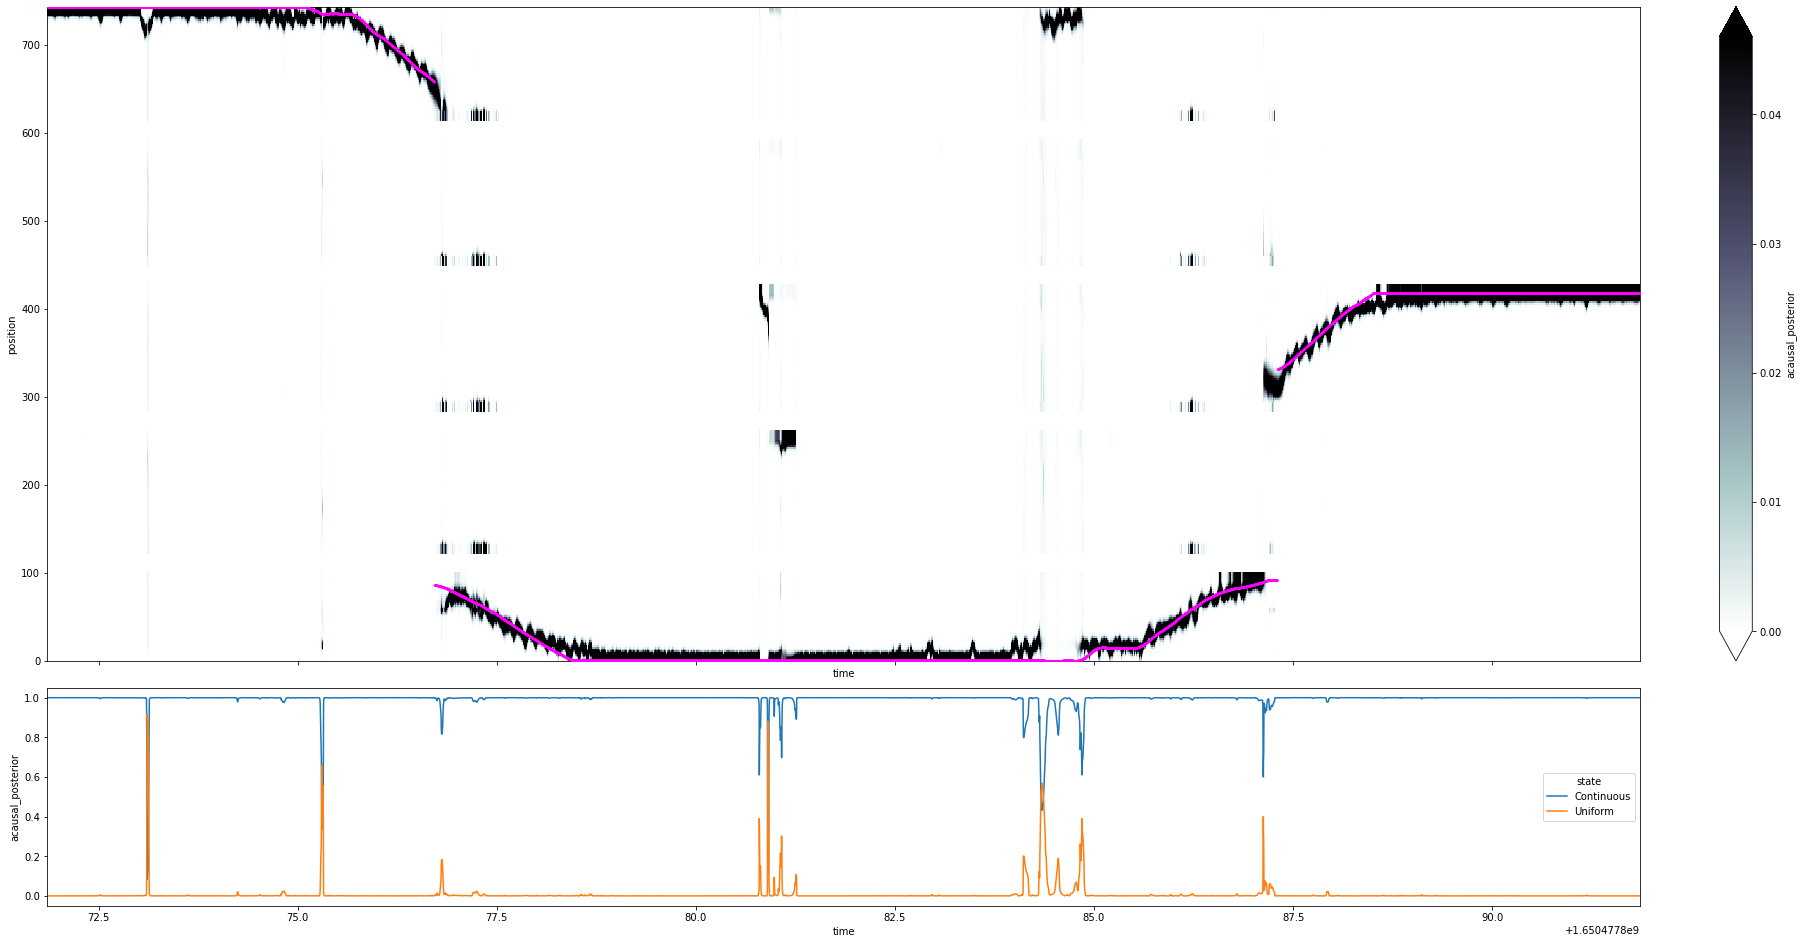

In [89]:
import matplotlib.pyplot as plt

time_slice = slice(180_000, 190_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(linear_position_df.iloc[time_slice].index,
                linear_position_df.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

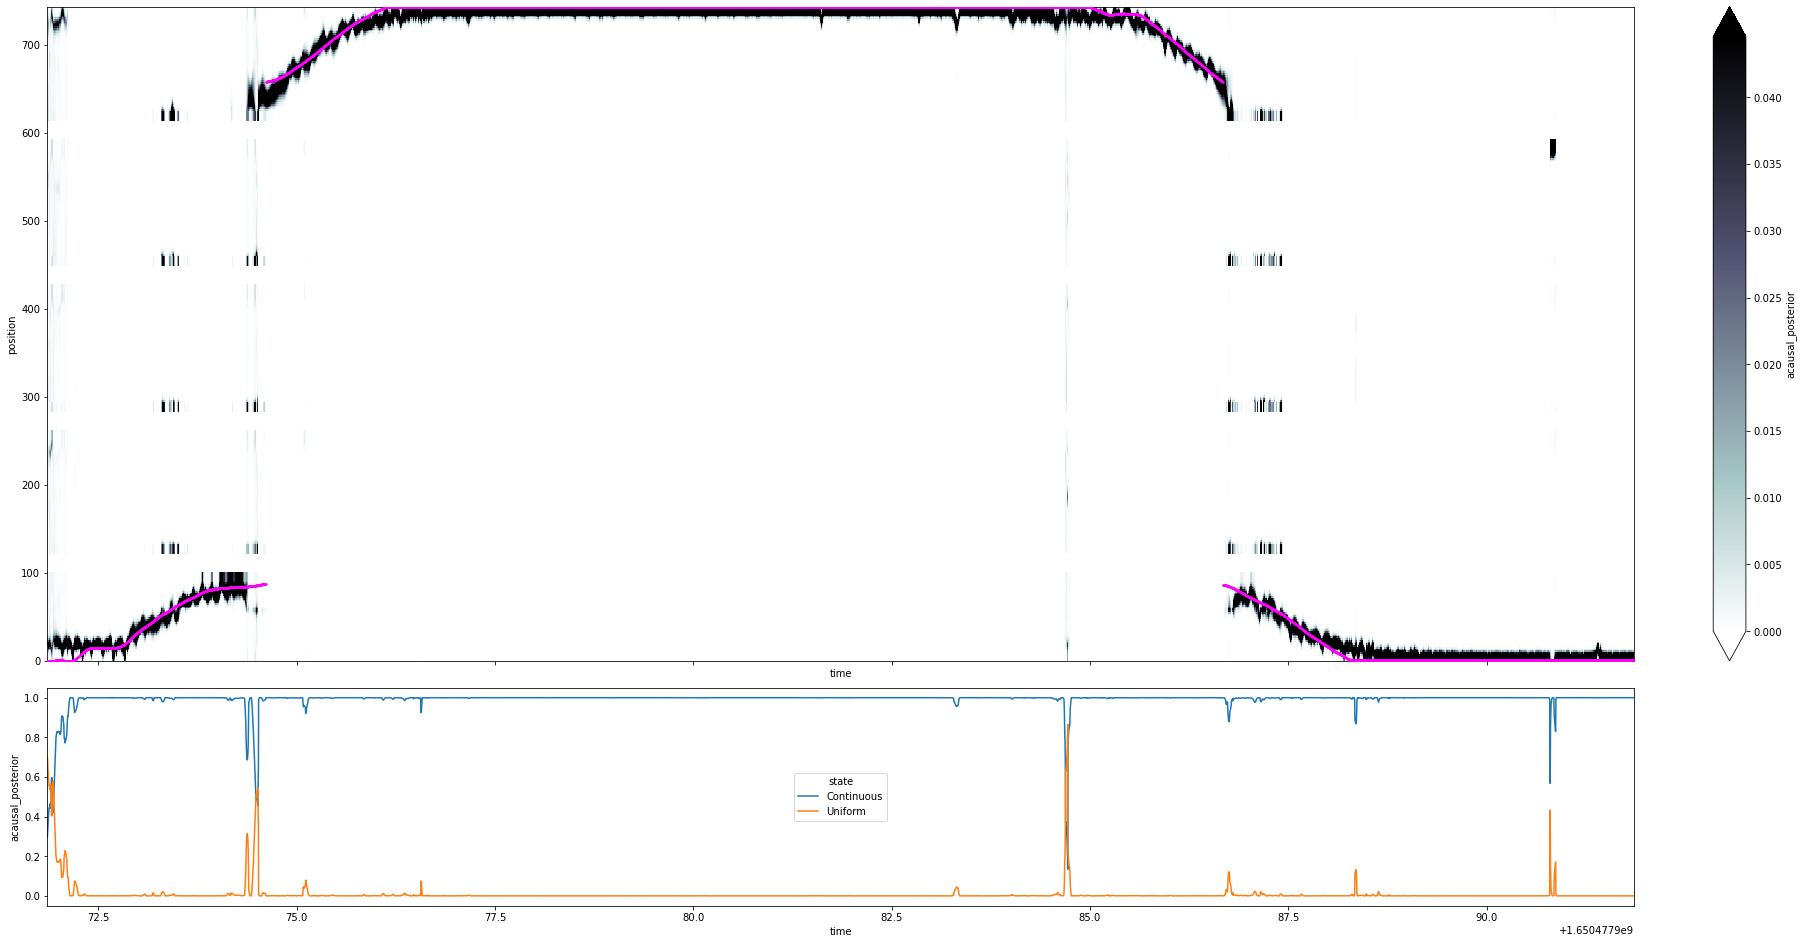

In [90]:
import matplotlib.pyplot as plt

time_slice = slice(230_000, 240_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(linear_position_df.iloc[time_slice].index,
                linear_position_df.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

In [91]:
from trajectory_analysis_tools import get_trajectory_data, get_ahead_behind_distance

trajectory_data = get_trajectory_data(
    results.sum('state').acausal_posterior,
    track_graph,
    classifier,
    linear_position_df[['projected_x_position', 'projected_y_position']],
    linear_position_df.track_segment_id,
    position_info.head_orientation,
)

ahead_behind_distance = get_ahead_behind_distance(
    track_graph, *trajectory_data)
mental_position_edges = trajectory_data[-1]
mental_position_edge_id = np.asarray(
    [track_graph.edges[edge]['edge_id'] for edge in mental_position_edges])

NameError: name 'position_info' is not defined

In [30]:
from ripple_detection import get_multiunit_population_firing_rate

SAMPLING_FREQUENCY = 500

multiunit_spikes = (np.any(~np.isnan(marks.values), axis=1)
                    ).astype(float)
multiunit_firing_rate = pd.DataFrame(
    get_multiunit_population_firing_rate(
        multiunit_spikes, SAMPLING_FREQUENCY), index=marks.time,
    columns=['firing_rate'])

In [31]:
from ripple_detection import multiunit_HSE_detector

multiunit_high_synchrony_times = multiunit_HSE_detector(
    marks.time.values,
    multiunit_spikes,
    position_info.head_speed.values,
    sampling_frequency=SAMPLING_FREQUENCY,
    minimum_duration=0.015,
    zscore_threshold=2.0,
    close_event_threshold=0.000)

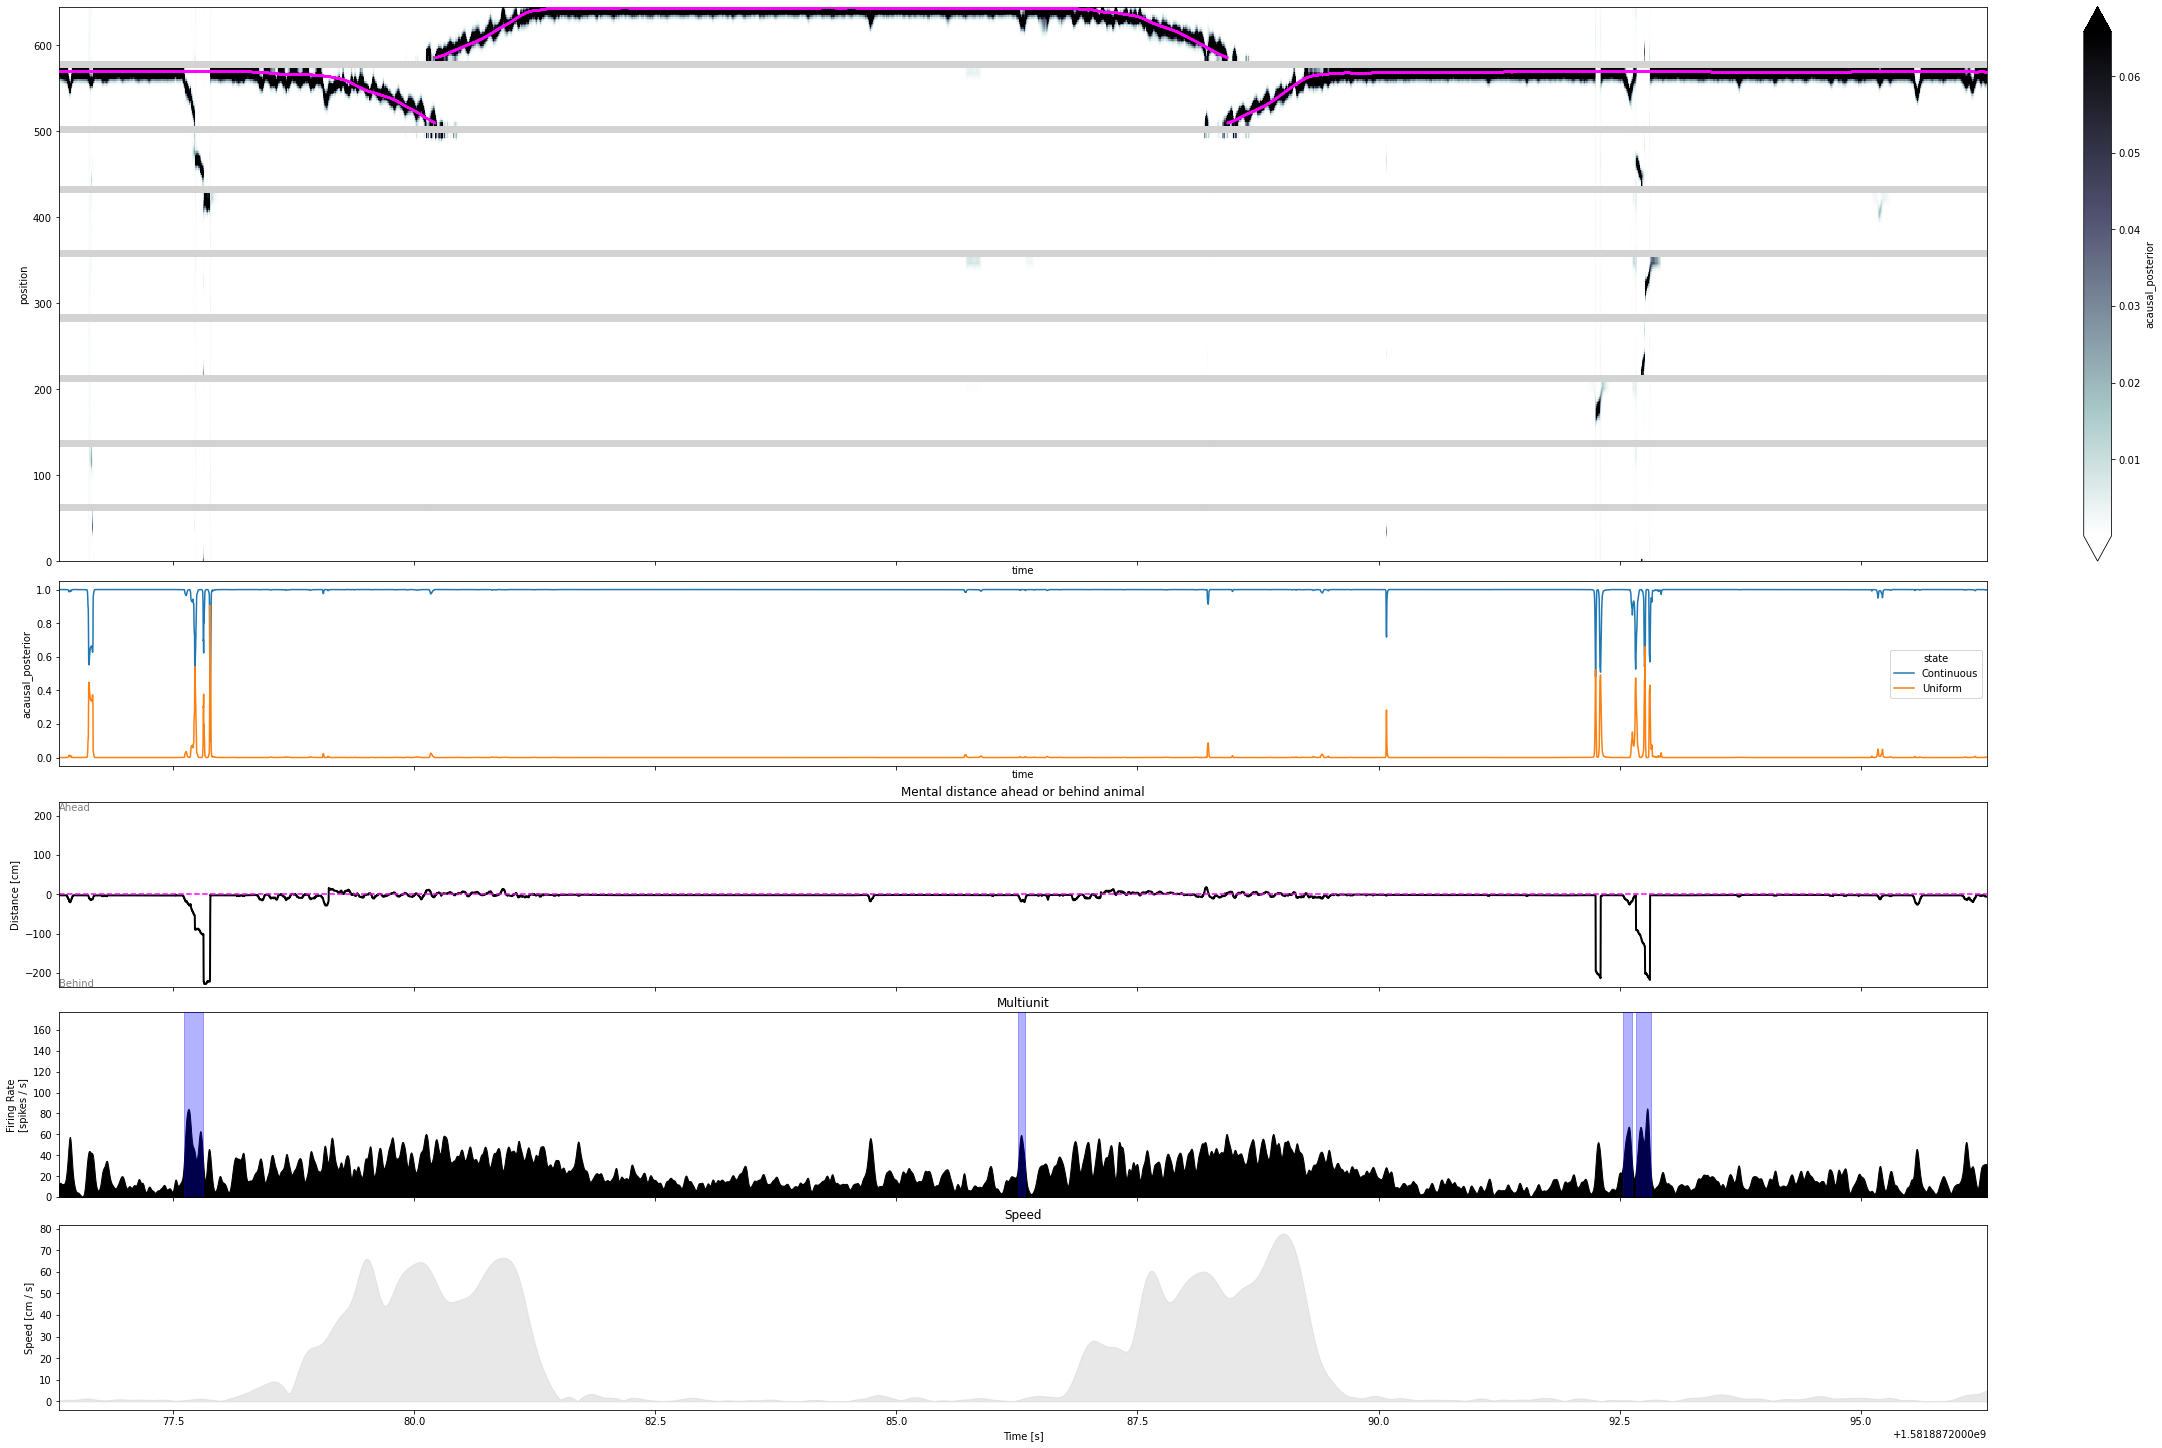

In [32]:
import matplotlib.pyplot as plt
import copy


def plot_classifier(
    time_slice,
    results,
    classifier,
    position_info,
    linear_position_df,
    ahead_behind_distance,
    multiunit_firing_rate,
    multiunit_high_synchrony_times,
    cmap='bone_r',
    figsize=(30, 20)
):

    cmap = copy.copy(plt.cm.get_cmap(cmap))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    fig, axes = plt.subplots(5, 1, figsize=figsize, sharex=True, constrained_layout=True,
                             gridspec_kw={"height_ratios": [3, 1, 1, 1, 1]},)

    time = results.isel(time=time_slice).time
    (results
     .isel(time=time_slice)
     .acausal_posterior
     .sum('state')
     .where(classifier.environments[0].is_track_interior_)
     .plot(x='time', y='position', ax=axes[0], robust=True, cmap=cmap))
    axes[0].scatter(time,
                    linear_position_df.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)

    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])
    axes[2].plot(time,
                 ahead_behind_distance[time_slice],
                 color="black", linewidth=2)
    axes[2].axhline(0, color="magenta", linestyle="--")
    axes[2].set_title("Mental distance ahead or behind animal")
    axes[2].set_ylabel("Distance [cm]")
    max_dist = np.max(np.abs(ahead_behind_distance)) + 5
    axes[2].set_ylim((-max_dist, max_dist))
    axes[2].text(time[0], max_dist - 1, "Ahead", color="grey", va='top')
    axes[2].text(time[0], -max_dist + 1, "Behind", color="grey")

    # ax 3
    axes[3].fill_between(
        multiunit_firing_rate.iloc[time_slice].index.values,
        multiunit_firing_rate.iloc[time_slice].values.squeeze(),
        color="black",
    )
    axes[3].set_ylabel("Firing Rate\n[spikes / s]")
    axes[3].set_title("Multiunit")
    axes[3].set_ylim((0.0, np.max(np.asarray(multiunit_firing_rate))))


    cur_multiunit_HSE = interval_list_intersect(
        np.asarray(multiunit_high_synchrony_times),
        np.asarray([(time[0], time[-1])]))

    for start_time, end_time in cur_multiunit_HSE:
        axes[3].axvspan(start_time, end_time, color='blue', alpha=0.3, zorder=10)

    # ax 4
    axes[4].fill_between(
        time,
        position_info.iloc[time_slice]
        .head_speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[4].set_title('Speed')
    axes[4].set_ylabel("Speed [cm / s]")
    axes[4].set_xlabel("Time [s]")
    

time_slice = slice(180_000, 190_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

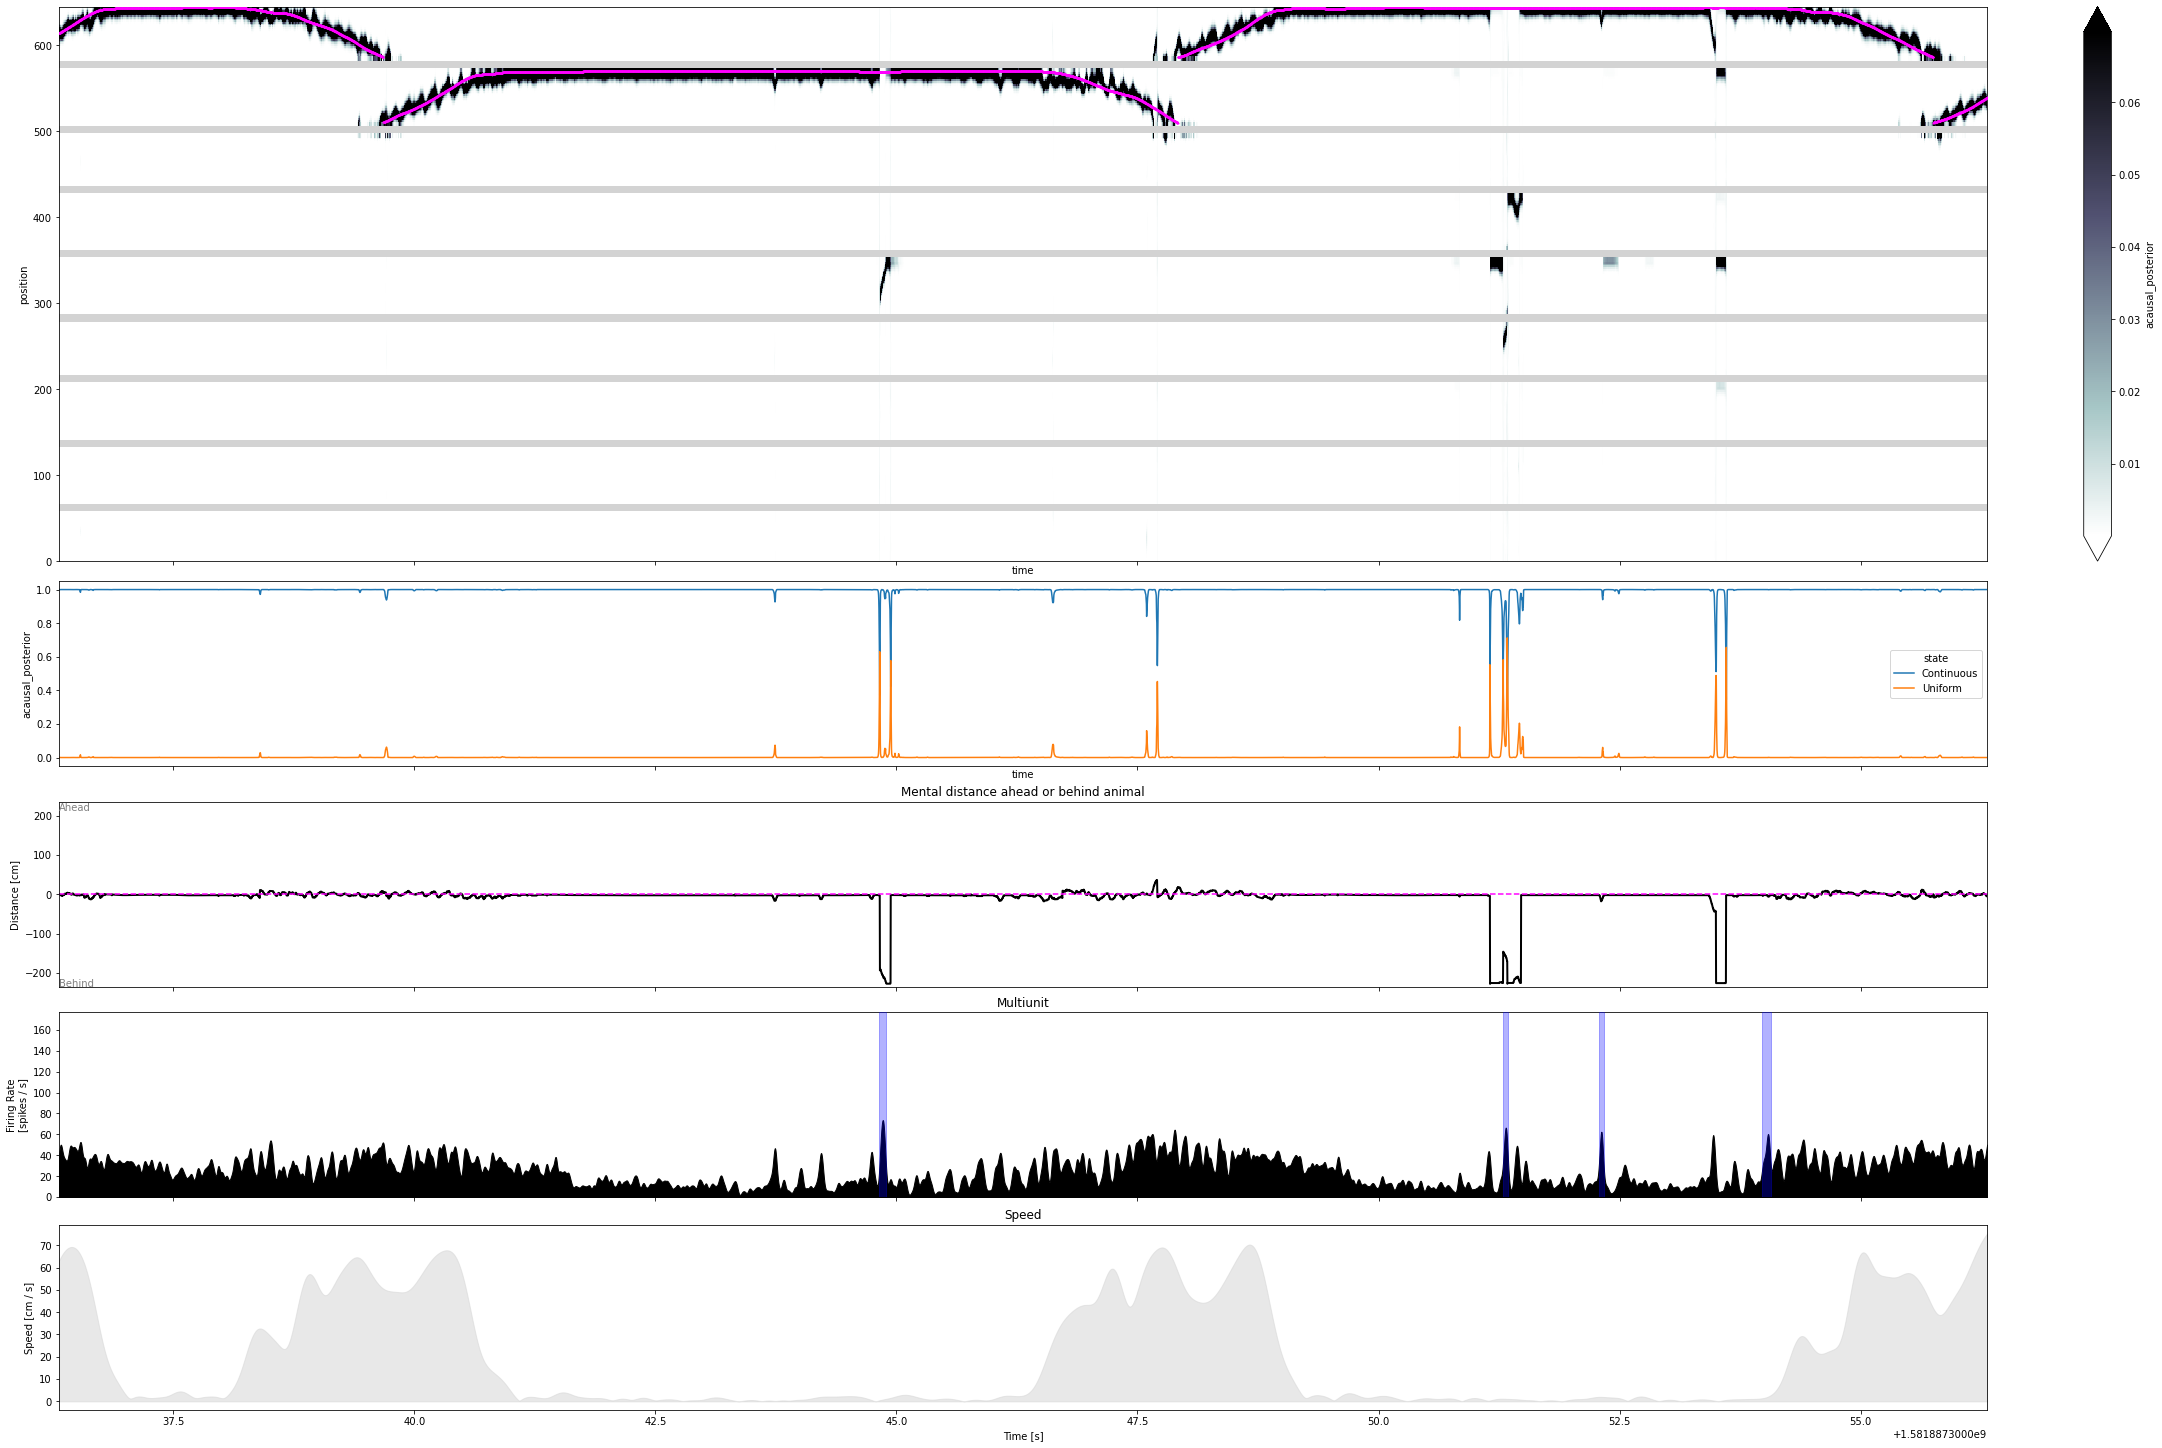

In [33]:
time_slice = slice(210_000, 220_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

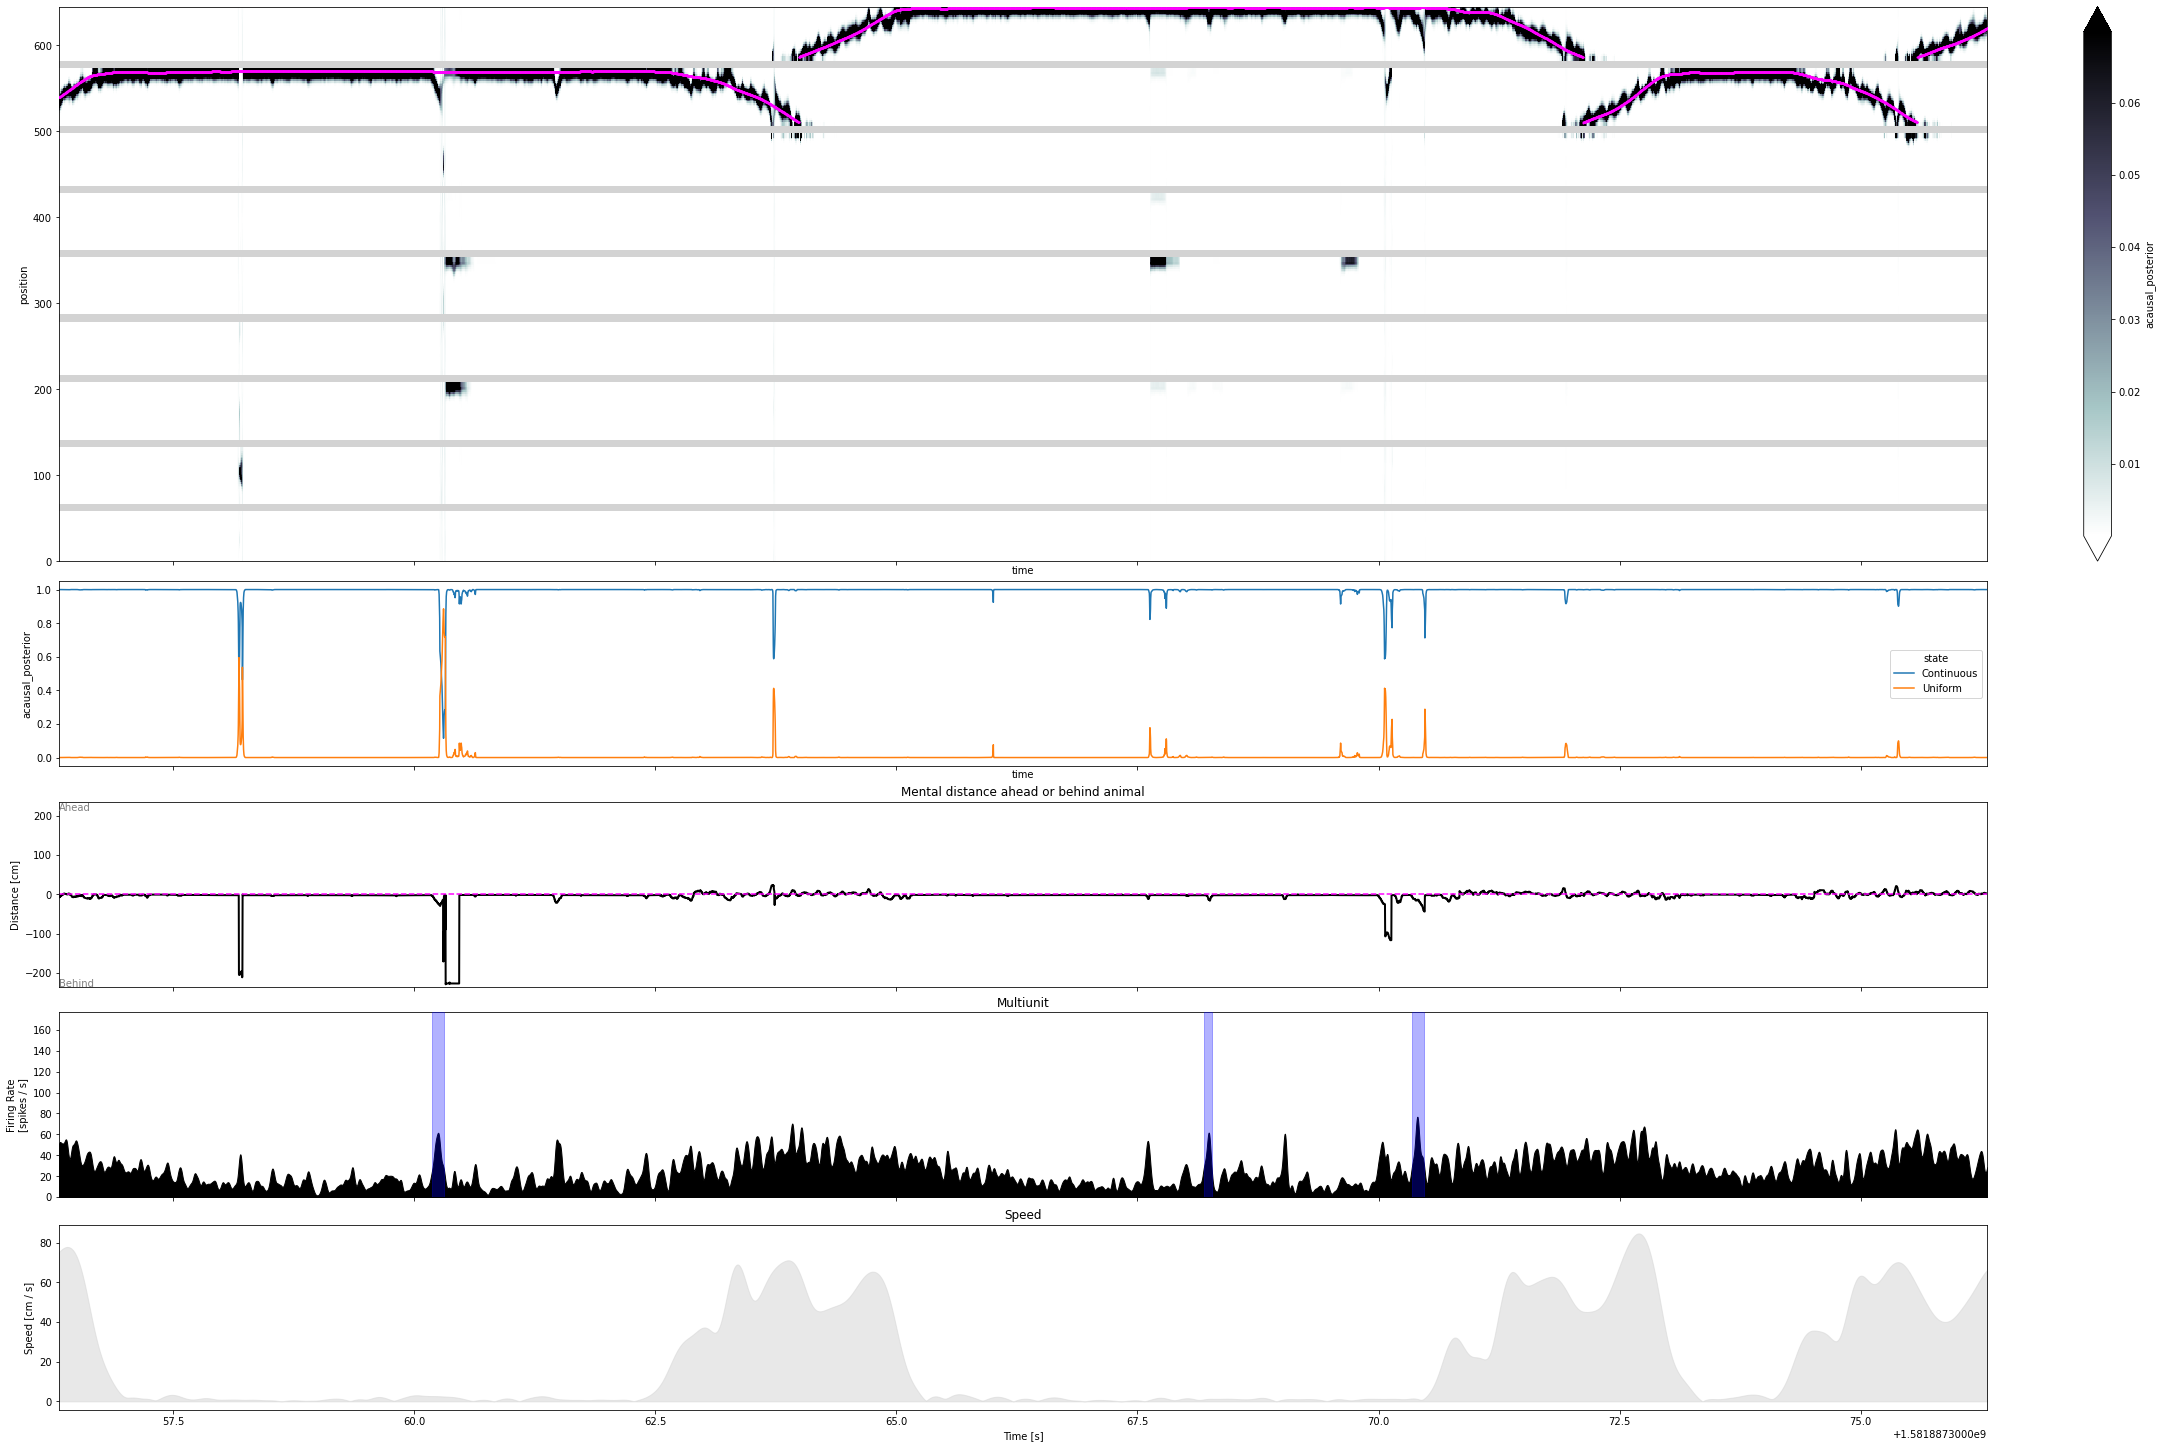

In [34]:
time_slice = slice(220_000, 230_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)